# Generación de señales ECG con GAN (LSTM)

> Objetivo: entrenar un modelo GAN con un generador basado en LSTM para sintetizar señales ECG de una clase específica (p. ej., NSR).

## Flujo del notebook
- Preparación del entorno y librerías
- Configuración (seed, dispositivo)
- Carga y exploración de datos
- Creación del DataLoader
- Definición de los modelos (Generator y Discriminator)
- Rutina de entrenamiento y monitoreo de pérdidas
- Guardado de modelos y métricas
- Notas y siguientes pasos

In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

In [3]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)
config.device

'cuda:0'

## Entorno y dispositivo

- Se fija la semilla para asegurar reproducibilidad.
- Se detecta automáticamente si hay GPU disponible.
- La celda siguiente imprime el estado de la GPU (nvidia-smi) para confirmar recursos.

In [4]:
!nvidia-smi

Thu Nov  6 21:50:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   40C    P8              7W /  300W |     972MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Carga de datos

- Definimos la ruta al CSV con señales ECG preprocesadas.
- El archivo esperado es `ECG_DATASET/dataset_ekg_df.csv`.
- `label` contiene la etiqueta textual y `class` la codificación numérica.
- Las columnas de señal son todas excepto las dos últimas (`[:-2]`).

In [5]:
path = "./ECG_DATASET/dataset_ekg_df.csv"
config.csv_path = path

config.csv_path

'./ECG_DATASET/dataset_ekg_df.csv'

In [6]:
df = pd.read_csv(config.csv_path)

### Vista rápida y ejemplo de señal

- Mostramos una señal de la clase NSR para verificar formato y escala.
- El eje X representa muestras; el eje Y, amplitud normalizada.

Text(0.5, 0, 'muestras')

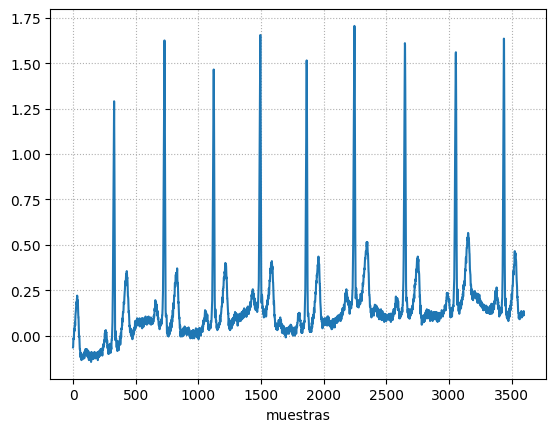

In [7]:
df[df["label"]=="NSR"].iloc[0,:-2].plot()
plt.grid(ls=":")
plt.xlabel("muestras")

## DataLoader personalizado

Esta sección construye un `Dataset` y un `DataLoader` para una clase específica:

- Filtra por `label` (ej. 'NSR').
- Convierte las señales a tensores `float32` con forma `(1, longitud)` para la red.
- Devuelve pares `(signal, target)` donde `target` es el índice numérico (`class`).
- `get_dataloader` vuelve a leer el CSV para permitir generar múltiples loaders de distintas clases si se quisiera.

In [8]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()
        # Pre-convertir los datos a arrays numpy para evitar warnings
        self.signals = self.df[self.data_columns].values.astype('float32')
        self.targets = self.df['class'].values.astype('int64')

    def __getitem__(self, idx):
        signal = torch.from_numpy(self.signals[idx]).unsqueeze(0)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader

In [9]:
dataloader = get_dataloader(label_name='NSR', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

3


(torch.Size([96, 1, 3600]), torch.Size([96]))

### Análisis de rango de datos

Es importante verificar el rango de las señales para asegurar que la normalización es adecuada.

In [10]:
# Verificar rango de datos
sample_signals, _ = next(iter(dataloader))
print(f"Rango de señales reales:")
print(f"  - Mínimo: {sample_signals.min().item():.4f}")
print(f"  - Máximo: {sample_signals.max().item():.4f}")
print(f"  - Media: {sample_signals.mean().item():.4f}")
print(f"  - Desv. estándar: {sample_signals.std().item():.4f}")
print(f"\nLas señales ya están normalizadas entre [{sample_signals.min().item():.2f}, {sample_signals.max().item():.2f}]")
print("El generador usa tanh que produce valores en [-1, 1], lo cual es compatible.")

Rango de señales reales:
  - Mínimo: -1.8195
  - Máximo: 3.0455
  - Media: -0.0344
  - Desv. estándar: 0.4550

Las señales ya están normalizadas entre [-1.82, 3.05]
El generador usa tanh que produce valores en [-1, 1], lo cual es compatible.


### Verificación del DataLoader

- Obtenemos un batch para comprobar las shapes de `x` y `y`.
- `x` debe ser `(B, 1, 3600)` y `y` `(B,)` si `signal_length=3600`.
- `len(dataloader)` indica cuántos batches hay por época.

## Arquitectura WGAN

### Generador (LSTM-based)
- **Input**: Vector de ruido (latent_dim)
- **LSTM**: Capas recurrentes para capturar dependencias temporales
- **Output**: Señal ECG sintética de longitud 3600

### Crítico (Discriminator)
- En WGAN, el discriminador se llama "crítico" y no usa sigmoid
- **Input**: Señal ECG (real o generada)
- **Conv1D**: Capas convolucionales para extraer características
- **Output**: Valor escalar (sin activación) que mide la "realidad" de la señal

### Diferencias clave de WGAN:
1. El crítico no tiene sigmoid al final
2. Pérdida basada en distancia de Wasserstein
3. Weight clipping o gradient penalty para satisfacer condición de Lipschitz

In [11]:
class Generator(nn.Module):
    """
    Generador mejorado con arquitectura de convoluciones transpuestas
    Input: ruido latente (batch, latent_dim)
    Output: señal ECG (batch, 1, signal_length)
    """
    def __init__(self, latent_dim=100, signal_length=3600):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.signal_length = signal_length
        
        # Calcular tamaño inicial después de la primera capa
        # Necesitamos llegar a 3600 con upsampling
        # 56 * 2^6 = 56 * 64 = 3584 ≈ 3600
        self.init_size = 56
        
        # Capa inicial: expandir latent vector
        self.fc = nn.Linear(latent_dim, 512 * self.init_size)
        
        # Capas de convolución transpuesta para upsampling
        self.conv_blocks = nn.Sequential(
            # 56 -> 112
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            # 112 -> 224
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # 224 -> 448
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # 448 -> 896
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # 896 -> 1792
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # 1792 -> 3584
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            
            # Capa final para obtener la señal
            nn.Conv1d(8, 1, kernel_size=17, stride=1, padding=8),
            nn.Tanh()
        )
        
    def forward(self, z):
        # z: (batch, latent_dim)
        x = self.fc(z)  # (batch, 512*init_size)
        x = x.view(x.size(0), 512, self.init_size)  # (batch, 512, init_size)
        x = self.conv_blocks(x)  # (batch, 1, ~3584)
        
        # Ajustar al tamaño exacto si es necesario
        if x.size(2) != self.signal_length:
            x = F.interpolate(x, size=self.signal_length, mode='linear', align_corners=False)
        
        return x

In [12]:
class Critic(nn.Module):
    """
    Crítico mejorado con arquitectura convolucional más profunda
    Input: señal ECG (batch, 1, signal_length)
    Output: valor escalar sin activación (Wasserstein distance estimate)
    """
    def __init__(self, signal_length=3600):
        super(Critic, self).__init__()
        
        # Capas convolucionales con arquitectura más robusta
        self.conv_blocks = nn.Sequential(
            # 3600 -> 1800
            nn.Conv1d(1, 16, kernel_size=15, stride=2, padding=7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 1800 -> 900
            nn.Conv1d(16, 32, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 900 -> 450
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 450 -> 225
            nn.Conv1d(64, 128, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 225 -> 112
            nn.Conv1d(128, 256, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            # 112 -> 56
            nn.Conv1d(256, 512, kernel_size=15, stride=2, padding=7),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
        )
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Capas fully connected
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        # x: (batch, 1, signal_length)
        x = self.conv_blocks(x)  # (batch, 512, ~56)
        x = self.global_pool(x)  # (batch, 512, 1)
        x = x.view(x.size(0), -1)  # (batch, 512)
        x = self.fc(x)  # (batch, 1)
        return x

## Instanciación de modelos

Creamos instancias del Generador y del Crítico, y los movemos al dispositivo configurado (GPU o CPU).

In [13]:
# Hiperparámetros mejorados
latent_dim = 128  # Aumentado para más variabilidad
signal_length = 3600
learning_rate_G = 0.0001  # LR más alto para el generador
learning_rate_C = 0.0002  # LR más alto para el crítico
n_critic = 5  # Entrenar el crítico 5 veces por cada entrenamiento del generador
clip_value = 0.01  # Para weight clipping

# Instanciar modelos mejorados
generator = Generator(latent_dim=latent_dim, signal_length=signal_length).to(config.device)
critic = Critic(signal_length=signal_length).to(config.device)

# Optimizadores (Adam suele funcionar mejor que RMSprop en práctica)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate_G, betas=(0.5, 0.9))
optimizer_C = torch.optim.Adam(critic.parameters(), lr=learning_rate_C, betas=(0.5, 0.9))

print(f"Generador: {sum(p.numel() for p in generator.parameters()):,} parámetros")
print(f"Crítico: {sum(p.numel() for p in critic.parameters()):,} parámetros")
print("\n✓ Modelos mejorados instanciados correctamente")
print(f"  - Learning rate Generator: {learning_rate_G}")
print(f"  - Learning rate Critic: {learning_rate_C}")
print(f"  - Latent dimension: {latent_dim}")

Generador: 4,399,217 parámetros
Crítico: 2,753,697 parámetros

✓ Modelos mejorados instanciados correctamente
  - Learning rate Generator: 0.0001
  - Learning rate Critic: 0.0002
  - Latent dimension: 128


## Loop de entrenamiento WGAN

### Algoritmo WGAN:
1. **Entrenar el Crítico (n_critic veces)**:
   - Generar señales fake
   - Calcular pérdida Wasserstein: `loss_C = -mean(C(real)) + mean(C(fake))`
   - Aplicar weight clipping a los parámetros del crítico
   
2. **Entrenar el Generador (1 vez)**:
   - Generar señales fake
   - Calcular pérdida: `loss_G = -mean(C(fake))`

### Métricas monitoreadas:
- `loss_C`: Pérdida del crítico (negativo de distancia de Wasserstein estimada)
- `loss_G`: Pérdida del generador
- `W_dist`: Distancia de Wasserstein aproximada (mayor es mejor al inicio)

In [14]:
def train_wgan(generator, critic, dataloader, optimizer_G, optimizer_C, 
               num_epochs=100, latent_dim=100, n_critic=5, clip_value=0.01, device='cuda'):
    """
    Entrena WGAN con weight clipping y monitoreo mejorado
    
    Args:
        generator: modelo generador
        critic: modelo crítico
        dataloader: DataLoader con señales reales
        optimizer_G: optimizador del generador
        optimizer_C: optimizador del crítico
        num_epochs: número de épocas
        latent_dim: dimensión del espacio latente
        n_critic: número de iteraciones del crítico por iteración del generador
        clip_value: valor para weight clipping
        device: dispositivo de cómputo
    
    Returns:
        history: diccionario con las pérdidas por época
    """
    
    generator.train()
    critic.train()
    
    history = {
        'loss_G': [],
        'loss_C': [],
        'W_dist': [],
        'critic_real': [],
        'critic_fake': []
    }
    
    for epoch in range(num_epochs):
        epoch_loss_G = []
        epoch_loss_C = []
        epoch_W_dist = []
        epoch_critic_real = []
        epoch_critic_fake = []
        
        for batch_idx, (real_signals, _) in enumerate(dataloader):
            real_signals = real_signals.to(device)
            batch_size = real_signals.size(0)
            
            # ==================== Entrenar Crítico ====================
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                
                # Generar señales fake
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_signals = generator(z).detach()  # detach para no calcular gradientes del generador
                
                # Calcular pérdida del crítico (Wasserstein loss)
                critic_real = critic(real_signals)
                critic_fake = critic(fake_signals)
                
                # Pérdida WGAN: maximizar E[C(real)] - E[C(fake)]
                # Equivalente a minimizar: -E[C(real)] + E[C(fake)]
                loss_C = -torch.mean(critic_real) + torch.mean(critic_fake)
                
                loss_C.backward()
                optimizer_C.step()
                
                # Weight clipping (importante para satisfacer condición de Lipschitz)
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)
            
            # ==================== Entrenar Generador ====================
            optimizer_G.zero_grad()
            
            # Generar nuevas señales fake
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_signals = generator(z)
            
            # Calcular pérdida del generador
            # Queremos maximizar E[C(fake)] = minimizar -E[C(fake)]
            critic_fake_g = critic(fake_signals)
            loss_G = -torch.mean(critic_fake_g)
            
            loss_G.backward()
            optimizer_G.step()
            
            # Guardar métricas
            epoch_loss_G.append(loss_G.item())
            epoch_loss_C.append(loss_C.item())
            epoch_critic_real.append(torch.mean(critic_real).item())
            epoch_critic_fake.append(torch.mean(critic_fake).item())
            
            # Distancia de Wasserstein aproximada (negativo de la pérdida del crítico)
            W_dist = -loss_C.item()
            epoch_W_dist.append(W_dist)
        
        # Promediar pérdidas de la época
        avg_loss_G = np.mean(epoch_loss_G)
        avg_loss_C = np.mean(epoch_loss_C)
        avg_W_dist = np.mean(epoch_W_dist)
        avg_critic_real = np.mean(epoch_critic_real)
        avg_critic_fake = np.mean(epoch_critic_fake)
        
        history['loss_G'].append(avg_loss_G)
        history['loss_C'].append(avg_loss_C)
        history['W_dist'].append(avg_W_dist)
        history['critic_real'].append(avg_critic_real)
        history['critic_fake'].append(avg_critic_fake)
        
        # Imprimir progreso con más detalle
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Época [{epoch+1:3d}/{num_epochs}] | "
                  f"Loss_G: {avg_loss_G:7.4f} | Loss_C: {avg_loss_C:7.4f} | "
                  f"W_dist: {avg_W_dist:7.4f} | C(real): {avg_critic_real:6.3f} | C(fake): {avg_critic_fake:6.3f}")
    
    return history

## Ejecutar entrenamiento

Entrenamos la WGAN durante el número de épocas especificado. Esto puede tomar tiempo dependiendo de tu hardware.

In [15]:
# Número de épocas de entrenamiento (empezar con menos para pruebas rápidas)
num_epochs = 5000  # Puedes aumentar a 300-500 para mejor calidad

# Entrenar la WGAN
print("Iniciando entrenamiento WGAN MEJORADO...")
print(f"Device: {config.device}")
print(f"Épocas: {num_epochs}")
print(f"Batch size: {dataloader.batch_size}")
print(f"Batches por época: {len(dataloader)}")
print(f"Latent dim: {latent_dim}")
print("=" * 80)

start_time = time.time()

history = train_wgan(
    generator=generator,
    critic=critic,
    dataloader=dataloader,
    optimizer_G=optimizer_G,
    optimizer_C=optimizer_C,
    num_epochs=num_epochs,
    latent_dim=latent_dim,
    n_critic=n_critic,
    clip_value=clip_value,
    device=config.device
)

elapsed_time = time.time() - start_time
print("=" * 80)
print(f"✓ Entrenamiento completado en {elapsed_time/60:.2f} minutos")
print(f"  Pérdida final Generator: {history['loss_G'][-1]:.4f}")
print(f"  Pérdida final Critic: {history['loss_C'][-1]:.4f}")
print(f"  Wasserstein distance final: {history['W_dist'][-1]:.4f}")

Iniciando entrenamiento WGAN MEJORADO...
Device: cuda:0
Épocas: 5000
Batch size: 96
Batches por época: 3
Latent dim: 128
Época [  1/5000] | Loss_G:  0.0117 | Loss_C: -0.0000 | W_dist:  0.0000 | C(real): -0.012 | C(fake): -0.012
Época [  5/5000] | Loss_G:  0.0120 | Loss_C: -0.0097 | W_dist:  0.0097 | C(real): -0.002 | C(fake): -0.012
Época [ 10/5000] | Loss_G:  0.0128 | Loss_C: -0.0307 | W_dist:  0.0307 | C(real):  0.018 | C(fake): -0.013
Época [ 15/5000] | Loss_G:  0.0120 | Loss_C: -0.0324 | W_dist:  0.0324 | C(real):  0.020 | C(fake): -0.012
Época [ 20/5000] | Loss_G:  0.0112 | Loss_C: -0.0327 | W_dist:  0.0327 | C(real):  0.022 | C(fake): -0.011
Época [ 25/5000] | Loss_G:  0.0104 | Loss_C: -0.0334 | W_dist:  0.0334 | C(real):  0.023 | C(fake): -0.010
Época [ 30/5000] | Loss_G:  0.0097 | Loss_C: -0.0336 | W_dist:  0.0336 | C(real):  0.024 | C(fake): -0.010
Época [ 35/5000] | Loss_G:  0.0098 | Loss_C: -0.0334 | W_dist:  0.0334 | C(real):  0.024 | C(fake): -0.010
Época [ 40/5000] | Loss

## 💡 Recomendaciones para mejorar la calidad

Si las señales aún no se ven realistas después del entrenamiento:

### Opción 1: Entrenar por MÁS tiempo
- **Actual**: 100 épocas
- **Recomendado**: 300-1000 épocas
- Las GANs mejoran gradualmente, la paciencia es clave

### Opción 2: Ajustar hiperparámetros
Prueba estas modificaciones una a la vez:
- Reducir `batch_size` a 32 o 64
- Aumentar `n_critic` a 8 o 10
- Reducir `learning_rate_C` a 0.0001

### Opción 3: Implementar WGAN-GP (más estable)
Gradient Penalty en lugar de weight clipping da mejor calidad

### Opción 4: Añadir ruido a las señales reales
Pequeñas perturbaciones pueden ayudar a la convergencia

## 🚀 Versión Mejorada: WGAN-GP (Gradient Penalty)

WGAN-GP reemplaza el weight clipping con gradient penalty, lo que resulta en:
- ✓ Entrenamiento más estable
- ✓ Mejor calidad de señales generadas
- ✓ Menos problemas de mode collapse
- ✓ No necesita clipping manual

La diferencia clave: en lugar de recortar pesos, penalizamos gradientes que no tienen norma 1.

## 🛠️ Funciones Auxiliares de Visualización

Funciones modulares para mantener el código organizado:

In [16]:
def plot_signals_comparison(real_signals, fake_signals, num_samples=4, figsize=(16, 10)):
    """
    Visualiza señales reales vs sintéticas lado a lado
    
    Args:
        real_signals: array numpy con señales reales (batch, channels, length)
        fake_signals: array numpy con señales sintéticas (batch, channels, length)
        num_samples: número de señales a mostrar
        figsize: tamaño de la figura
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=figsize)
    fig.suptitle('Señales Reales vs Sintéticas', fontsize=14, fontweight='bold')
    
    for i in range(num_samples):
        # Señal real
        axes[i, 0].plot(real_signals[i, 0, :], color='blue', alpha=0.8, linewidth=0.7)
        axes[i, 0].set_title(f'Real NSR #{i+1}', fontsize=10)
        axes[i, 0].set_ylim(-2, 2)
        axes[i, 0].grid(ls=':', alpha=0.3)
        if i == num_samples - 1:
            axes[i, 0].set_xlabel('Muestras')
        
        # Señal sintética
        axes[i, 1].plot(fake_signals[i, 0, :], color='orange', alpha=0.8, linewidth=0.7)
        axes[i, 1].set_title(f'Sintética #{i+1}', fontsize=10)
        axes[i, 1].set_ylim(-2, 2)
        axes[i, 1].grid(ls=':', alpha=0.3)
        if i == num_samples - 1:
            axes[i, 1].set_xlabel('Muestras')
    
    plt.tight_layout()
    return fig


def plot_training_metrics(history, current_epoch=None):
    """
    Visualiza métricas de entrenamiento (losses, W-distance, etc.)
    
    Args:
        history: diccionario con métricas
        current_epoch: época actual (None para mostrar todas)
    """
    if current_epoch is not None:
        epochs = list(range(1, current_epoch + 2))
    else:
        epochs = list(range(1, len(history['loss_G']) + 1))
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('Métricas de Entrenamiento WGAN-GP', fontsize=14, fontweight='bold')
    
    # Loss Generator
    axes[0, 0].plot(epochs, history['loss_G'][:len(epochs)], 'b-', linewidth=2, alpha=0.7)
    axes[0, 0].set_title('Pérdida del Generador')
    axes[0, 0].set_ylabel('Loss G')
    axes[0, 0].grid(ls=':', alpha=0.3)
    
    # Loss Critic
    axes[0, 1].plot(epochs, history['loss_C'][:len(epochs)], 'r-', linewidth=2, alpha=0.7)
    axes[0, 1].set_title('Pérdida del Crítico')
    axes[0, 1].set_ylabel('Loss C')
    axes[0, 1].grid(ls=':', alpha=0.3)
    
    # Wasserstein Distance
    axes[1, 0].plot(epochs, history['W_dist'][:len(epochs)], 'g-', linewidth=2, alpha=0.7)
    axes[1, 0].set_title('Distancia de Wasserstein')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('W-dist')
    axes[1, 0].grid(ls=':', alpha=0.3)
    
    # Critic Scores
    axes[1, 1].plot(epochs, history['critic_real'][:len(epochs)], 'b-', 
                   linewidth=2, alpha=0.7, label='C(real)')
    axes[1, 1].plot(epochs, history['critic_fake'][:len(epochs)], 'orange', 
                   linewidth=2, alpha=0.7, label='C(fake)')
    axes[1, 1].set_title('Scores del Crítico')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(ls=':', alpha=0.3)
    axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return fig


def print_signal_statistics(real_signals, fake_signals, epoch=None):
    """
    Imprime estadísticas comparativas de señales reales vs sintéticas
    
    Args:
        real_signals: array numpy con señales reales
        fake_signals: array numpy con señales sintéticas
        epoch: número de época (opcional)
    """
    if epoch is not None:
        print(f"\n📊 Estadísticas época {epoch}:")
    else:
        print("\n📊 Estadísticas de señales:")
    
    print(f"  Real      - Min: {real_signals.min():7.3f}, Max: {real_signals.max():7.3f}, "
          f"Mean: {real_signals.mean():7.3f}, Std: {real_signals.std():7.3f}")
    print(f"  Sintética - Min: {fake_signals.min():7.3f}, Max: {fake_signals.max():7.3f}, "
          f"Mean: {fake_signals.mean():7.3f}, Std: {fake_signals.std():7.3f}")
    
    # Calcular similitud en rangos
    range_real = real_signals.max() - real_signals.min()
    range_fake = fake_signals.max() - fake_signals.min()
    print(f"  Rango real: {range_real:.3f}, Rango sintético: {range_fake:.3f}")


def visualize_training_progress(generator, fixed_z, real_sample, history, epoch, num_epochs, device):
    """
    Visualización completa durante el entrenamiento (señales + métricas)
    
    Args:
        generator: modelo generador
        fixed_z: vector latente fijo para visualización consistente
        real_sample: muestra de señales reales
        history: diccionario con métricas
        epoch: época actual
        num_epochs: total de épocas
        device: dispositivo de cómputo
    """
    generator.eval()
    with torch.no_grad():
        # Generar señales con el vector latente fijo
        fake_vis = generator(fixed_z).cpu().numpy()
        real_vis = real_sample.cpu().numpy()
        
        # Crear figura combinada
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
        
        # Título principal
        fig.suptitle(f'Época {epoch+1}/{num_epochs} - Progreso del Entrenamiento', 
                   fontsize=16, fontweight='bold')
        
        # === SEÑALES REALES VS SINTÉTICAS ===
        for i in range(4):
            # Señal real
            ax_real = fig.add_subplot(gs[i, 0])
            ax_real.plot(real_vis[i, 0, :], color='blue', alpha=0.8, linewidth=0.7)
            ax_real.set_title(f'Real NSR #{i+1}', fontsize=10)
            ax_real.set_ylim(-2, 2)
            ax_real.grid(ls=':', alpha=0.3)
            if i == 3:
                ax_real.set_xlabel('Muestras')
            
            # Señal sintética
            ax_fake = fig.add_subplot(gs[i, 1])
            ax_fake.plot(fake_vis[i, 0, :], color='orange', alpha=0.8, linewidth=0.7)
            ax_fake.set_title(f'Sintética #{i+1}', fontsize=10)
            ax_fake.set_ylim(-2, 2)
            ax_fake.grid(ls=':', alpha=0.3)
            if i == 3:
                ax_fake.set_xlabel('Muestras')
        
        # === GRÁFICAS DE MÉTRICAS ===
        epochs_so_far = list(range(1, epoch + 2))
        
        # Loss Generator
        ax1 = fig.add_subplot(gs[0, 2:])
        ax1.plot(epochs_so_far, history['loss_G'], 'b-', linewidth=2, alpha=0.7)
        ax1.set_title('Pérdida del Generador', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Loss G')
        ax1.grid(ls=':', alpha=0.3)
        
        # Loss Critic
        ax2 = fig.add_subplot(gs[1, 2:])
        ax2.plot(epochs_so_far, history['loss_C'], 'r-', linewidth=2, alpha=0.7)
        ax2.set_title('Pérdida del Crítico', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Loss C')
        ax2.grid(ls=':', alpha=0.3)
        
        # Wasserstein Distance
        ax3 = fig.add_subplot(gs[2, 2:])
        ax3.plot(epochs_so_far, history['W_dist'], 'g-', linewidth=2, alpha=0.7)
        ax3.set_title('Distancia de Wasserstein', fontsize=11, fontweight='bold')
        ax3.set_ylabel('W-dist')
        ax3.grid(ls=':', alpha=0.3)
        
        # Critic Scores
        ax4 = fig.add_subplot(gs[3, 2:])
        ax4.plot(epochs_so_far, history['critic_real'], 'b-', linewidth=2, alpha=0.7, label='C(real)')
        ax4.plot(epochs_so_far, history['critic_fake'], 'orange', linewidth=2, alpha=0.7, label='C(fake)')
        ax4.set_title('Scores del Crítico', fontsize=11, fontweight='bold')
        ax4.set_xlabel('Época')
        ax4.set_ylabel('Score')
        ax4.legend()
        ax4.grid(ls=':', alpha=0.3)
        ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        plt.show()
        
        # Imprimir estadísticas
        print_signal_statistics(real_vis, fake_vis, epoch=epoch+1)
        
        # Separación del crítico
        avg_critic_real = history['critic_real'][-1]
        avg_critic_fake = history['critic_fake'][-1]
        print(f"  Separación C(real)-C(fake): {avg_critic_real - avg_critic_fake:.4f}\n")
    
    generator.train()

print("✓ Funciones auxiliares de visualización cargadas")

✓ Funciones auxiliares de visualización cargadas


In [17]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """
    Calcula el gradient penalty para WGAN-GP
    
    Args:
        critic: modelo crítico
        real_samples: señales reales (batch, 1, signal_length)
        fake_samples: señales generadas (batch, 1, signal_length)
        device: dispositivo de cómputo
    
    Returns:
        gradient_penalty: penalización de gradiente
    """
    batch_size = real_samples.size(0)
    
    # Generar números aleatorios para interpolación
    alpha = torch.rand(batch_size, 1, 1).to(device)
    
    # Interpolar entre señales reales y fake
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Calcular la salida del crítico para las interpolaciones
    d_interpolates = critic(interpolates)
    
    # Calcular gradientes
    fake = torch.ones(batch_size, 1).to(device).requires_grad_(False)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Aplanar los gradientes
    gradients = gradients.view(batch_size, -1)
    
    # Calcular la norma de los gradientes
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [18]:
def train_wgan_gp(generator, critic, dataloader, optimizer_G, optimizer_C, 
                  num_epochs=100, latent_dim=100, n_critic=5, lambda_gp=10, device='cuda',
                  visualize_every=50):
    """
    Entrena WGAN con Gradient Penalty con visualización durante el entrenamiento
    
    Args:
        generator: modelo generador
        critic: modelo crítico
        dataloader: DataLoader con señales reales
        optimizer_G: optimizador del generador
        optimizer_C: optimizador del crítico
        num_epochs: número de épocas
        latent_dim: dimensión del espacio latente
        n_critic: número de iteraciones del crítico por iteración del generador
        lambda_gp: peso de la gradient penalty (típicamente 10)
        device: dispositivo de cómputo
        visualize_every: visualizar cada N épocas (default: 50)
    
    Returns:
        history: diccionario con las pérdidas por época
    """
    
    generator.train()
    critic.train()
    
    history = {
        'loss_G': [],
        'loss_C': [],
        'W_dist': [],
        'gp': [],
        'critic_real': [],
        'critic_fake': []
    }
    
    # Vector latente fijo para visualización consistente
    fixed_z = torch.randn(4, latent_dim).to(device)
    
    # Obtener una muestra de señales reales para comparación
    real_sample, _ = next(iter(dataloader))
    real_sample = real_sample[:4].to(device)
    
    for epoch in range(num_epochs):
        epoch_loss_G = []
        epoch_loss_C = []
        epoch_W_dist = []
        epoch_gp = []
        epoch_critic_real = []
        epoch_critic_fake = []
        
        for batch_idx, (real_signals, _) in enumerate(dataloader):
            real_signals = real_signals.to(device)
            batch_size = real_signals.size(0)
            
            # ==================== Entrenar Crítico ====================
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                
                # Generar señales fake
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_signals = generator(z).detach()
                
                # Calcular pérdida del crítico (Wasserstein loss)
                critic_real = critic(real_signals)
                critic_fake = critic(fake_signals)
                
                # Calcular gradient penalty
                gradient_penalty = compute_gradient_penalty(
                    critic, real_signals, fake_signals, device
                )
                
                # Pérdida total del crítico
                # WGAN-GP: minimizar -E[C(real)] + E[C(fake)] + lambda * GP
                loss_C = -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gradient_penalty
                
                loss_C.backward()
                optimizer_C.step()
            
            # ==================== Entrenar Generador ====================
            optimizer_G.zero_grad()
            
            # Generar nuevas señales fake
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_signals = generator(z)
            
            # Calcular pérdida del generador
            critic_fake_g = critic(fake_signals)
            loss_G = -torch.mean(critic_fake_g)
            
            loss_G.backward()
            optimizer_G.step()
            
            # Guardar métricas
            epoch_loss_G.append(loss_G.item())
            epoch_loss_C.append(loss_C.item())
            epoch_gp.append(gradient_penalty.item())
            epoch_critic_real.append(torch.mean(critic_real).item())
            epoch_critic_fake.append(torch.mean(critic_fake).item())
            
            # Distancia de Wasserstein (sin GP)
            W_dist = torch.mean(critic_real).item() - torch.mean(critic_fake).item()
            epoch_W_dist.append(W_dist)
        
        # Promediar métricas de la época
        avg_loss_G = np.mean(epoch_loss_G)
        avg_loss_C = np.mean(epoch_loss_C)
        avg_W_dist = np.mean(epoch_W_dist)
        avg_gp = np.mean(epoch_gp)
        avg_critic_real = np.mean(epoch_critic_real)
        avg_critic_fake = np.mean(epoch_critic_fake)
        
        history['loss_G'].append(avg_loss_G)
        history['loss_C'].append(avg_loss_C)
        history['W_dist'].append(avg_W_dist)
        history['gp'].append(avg_gp)
        history['critic_real'].append(avg_critic_real)
        history['critic_fake'].append(avg_critic_fake)
        
        # Imprimir progreso
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Época [{epoch+1:3d}/{num_epochs}] | "
                  f"Loss_G: {avg_loss_G:7.4f} | Loss_C: {avg_loss_C:7.4f} | "
                  f"W_dist: {avg_W_dist:7.4f} | GP: {avg_gp:6.3f} | "
                  f"C(real): {avg_critic_real:6.3f} | C(fake): {avg_critic_fake:6.3f}")
        
        # ==================== VISUALIZACIÓN DURANTE ENTRENAMIENTO ====================
        if (epoch + 1) % visualize_every == 0 or epoch == 0:
            generator.eval()
            with torch.no_grad():
                # Generar señales con el vector latente fijo
                fake_vis = generator(fixed_z).cpu().numpy()
                real_vis = real_sample.cpu().numpy()
                
                # Crear figura con señales y métricas
                fig = plt.figure(figsize=(20, 12))
                gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
                
                # Título principal
                fig.suptitle(f'Época {epoch+1}/{num_epochs} - Progreso del Entrenamiento', 
                           fontsize=16, fontweight='bold')
                
                # === SEÑALES REALES VS SINTÉTICAS ===
                for i in range(4):
                    # Señal real
                    ax_real = fig.add_subplot(gs[i, 0])
                    ax_real.plot(real_vis[i, 0, :], color='blue', alpha=0.8, linewidth=0.7)
                    ax_real.set_title(f'Real NSR #{i+1}', fontsize=10)
                    ax_real.set_ylim(-2, 2)
                    ax_real.grid(ls=':', alpha=0.3)
                    if i == 3:
                        ax_real.set_xlabel('Muestras')
                    
                    # Señal sintética
                    ax_fake = fig.add_subplot(gs[i, 1])
                    ax_fake.plot(fake_vis[i, 0, :], color='orange', alpha=0.8, linewidth=0.7)
                    ax_fake.set_title(f'Sintética #{i+1}', fontsize=10)
                    ax_fake.set_ylim(-2, 2)
                    ax_fake.grid(ls=':', alpha=0.3)
                    if i == 3:
                        ax_fake.set_xlabel('Muestras')
                
                # === GRÁFICAS DE PÉRDIDAS ===
                epochs_so_far = list(range(1, epoch + 2))
                
                # Loss Generator
                ax1 = fig.add_subplot(gs[0, 2:])
                ax1.plot(epochs_so_far, history['loss_G'], 'b-', linewidth=2, alpha=0.7)
                ax1.set_title('Pérdida del Generador', fontsize=11, fontweight='bold')
                ax1.set_ylabel('Loss G')
                ax1.grid(ls=':', alpha=0.3)
                
                # Loss Critic
                ax2 = fig.add_subplot(gs[1, 2:])
                ax2.plot(epochs_so_far, history['loss_C'], 'r-', linewidth=2, alpha=0.7)
                ax2.set_title('Pérdida del Crítico', fontsize=11, fontweight='bold')
                ax2.set_ylabel('Loss C')
                ax2.grid(ls=':', alpha=0.3)
                
                # Wasserstein Distance
                ax3 = fig.add_subplot(gs[2, 2:])
                ax3.plot(epochs_so_far, history['W_dist'], 'g-', linewidth=2, alpha=0.7)
                ax3.set_title('Distancia de Wasserstein', fontsize=11, fontweight='bold')
                ax3.set_ylabel('W-dist')
                ax3.grid(ls=':', alpha=0.3)
                
                # Critic Scores
                ax4 = fig.add_subplot(gs[3, 2:])
                ax4.plot(epochs_so_far, history['critic_real'], 'b-', linewidth=2, alpha=0.7, label='C(real)')
                ax4.plot(epochs_so_far, history['critic_fake'], 'orange', linewidth=2, alpha=0.7, label='C(fake)')
                ax4.set_title('Scores del Crítico', fontsize=11, fontweight='bold')
                ax4.set_xlabel('Época')
                ax4.set_ylabel('Score')
                ax4.legend()
                ax4.grid(ls=':', alpha=0.3)
                ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                
                plt.show()
                
                # Estadísticas
                print(f"\n📊 Estadísticas época {epoch+1}:")
                print(f"  Real    - Min: {real_vis.min():.3f}, Max: {real_vis.max():.3f}, "
                      f"Mean: {real_vis.mean():.3f}, Std: {real_vis.std():.3f}")
                print(f"  Sintética - Min: {fake_vis.min():.3f}, Max: {fake_vis.max():.3f}, "
                      f"Mean: {fake_vis.mean():.3f}, Std: {fake_vis.std():.3f}")
                print(f"  Separación C(real)-C(fake): {avg_critic_real - avg_critic_fake:.4f}\n")
            
            generator.train()
    
    return history

## 🔄 Versión Refactorizada de train_wgan_gp

Versión más limpia y modular usando las funciones auxiliares:

In [19]:
def train_wgan_gp_refactored(generator, critic, dataloader, optimizer_G, optimizer_C, 
                             num_epochs=100, latent_dim=100, n_critic=5, lambda_gp=10, 
                             device='cuda', visualize_every=50, print_every=10):
    """
    Versión refactorizada y mejorada de entrenamiento WGAN-GP
    Usa funciones auxiliares para mantener el código más limpio y modular
    
    Args:
        generator: modelo generador
        critic: modelo crítico
        dataloader: DataLoader con señales reales
        optimizer_G: optimizador del generador
        optimizer_C: optimizador del crítico
        num_epochs: número de épocas
        latent_dim: dimensión del espacio latente
        n_critic: iteraciones del crítico por iteración del generador
        lambda_gp: peso de la gradient penalty (default: 10)
        device: dispositivo de cómputo
        visualize_every: mostrar visualización cada N épocas (default: 50)
        print_every: imprimir métricas cada N épocas (default: 10)
    
    Returns:
        history: diccionario con métricas del entrenamiento
    """
    
    # Configurar modelos en modo entrenamiento
    generator.train()
    critic.train()
    
    # Inicializar historial de métricas
    history = {
        'loss_G': [],
        'loss_C': [],
        'W_dist': [],
        'gp': [],
        'critic_real': [],
        'critic_fake': []
    }
    
    # Preparar datos fijos para visualización consistente
    fixed_z = torch.randn(4, latent_dim).to(device)
    real_sample, _ = next(iter(dataloader))
    real_sample = real_sample[:4].to(device)
    
    print(f"🚀 Iniciando entrenamiento WGAN-GP")
    print(f"   Épocas: {num_epochs}")
    print(f"   Batch size: {dataloader.batch_size}")
    print(f"   Learning rates: G={optimizer_G.param_groups[0]['lr']:.5f}, C={optimizer_C.param_groups[0]['lr']:.5f}")
    print(f"   Lambda GP: {lambda_gp}")
    print(f"   n_critic: {n_critic}")
    print("=" * 80)
    
    # Loop de entrenamiento
    for epoch in range(num_epochs):
        # Listas para acumular métricas del epoch
        epoch_metrics = {
            'loss_G': [],
            'loss_C': [],
            'W_dist': [],
            'gp': [],
            'critic_real': [],
            'critic_fake': []
        }
        
        # Iterar sobre batches
        for batch_idx, (real_signals, _) in enumerate(dataloader):
            real_signals = real_signals.to(device)
            batch_size = real_signals.size(0)
            
            # ==================== ENTRENAR CRÍTICO ====================
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                
                # Generar señales falsas
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_signals = generator(z).detach()
                
                # Evaluar crítico
                critic_real_scores = critic(real_signals)
                critic_fake_scores = critic(fake_signals)
                
                # Calcular gradient penalty
                gp = compute_gradient_penalty(critic, real_signals, fake_signals, device)
                
                # Loss del crítico: -E[C(real)] + E[C(fake)] + λ*GP
                loss_C = -torch.mean(critic_real_scores) + torch.mean(critic_fake_scores) + lambda_gp * gp
                
                loss_C.backward()
                optimizer_C.step()
            
            # ==================== ENTRENAR GENERADOR ====================
            optimizer_G.zero_grad()
            
            # Generar nuevas señales
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_signals = generator(z)
            
            # Loss del generador: -E[C(fake)]
            critic_fake_g = critic(fake_signals)
            loss_G = -torch.mean(critic_fake_g)
            
            loss_G.backward()
            optimizer_G.step()
            
            # Guardar métricas del batch
            epoch_metrics['loss_G'].append(loss_G.item())
            epoch_metrics['loss_C'].append(loss_C.item())
            epoch_metrics['gp'].append(gp.item())
            epoch_metrics['critic_real'].append(torch.mean(critic_real_scores).item())
            epoch_metrics['critic_fake'].append(torch.mean(critic_fake_scores).item())
            
            # Distancia de Wasserstein (sin gradient penalty)
            W_dist = torch.mean(critic_real_scores).item() - torch.mean(critic_fake_scores).item()
            epoch_metrics['W_dist'].append(W_dist)
        
        # ==================== GUARDAR MÉTRICAS DE LA ÉPOCA ====================
        for key in history.keys():
            avg_metric = np.mean(epoch_metrics[key])
            history[key].append(avg_metric)
        
        # ==================== IMPRIMIR PROGRESO ====================
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Época [{epoch+1:4d}/{num_epochs}] | "
                  f"Loss_G: {history['loss_G'][-1]:8.4f} | "
                  f"Loss_C: {history['loss_C'][-1]:8.4f} | "
                  f"W_dist: {history['W_dist'][-1]:8.4f} | "
                  f"GP: {history['gp'][-1]:6.3f} | "
                  f"C(real): {history['critic_real'][-1]:7.3f} | "
                  f"C(fake): {history['critic_fake'][-1]:7.3f}")
        
        # ==================== VISUALIZACIÓN ====================
        if (epoch + 1) % visualize_every == 0 or epoch == 0:
            visualize_training_progress(
                generator=generator,
                fixed_z=fixed_z,
                real_sample=real_sample,
                history=history,
                epoch=epoch,
                num_epochs=num_epochs,
                device=device
            )
    
    print("=" * 80)
    print("✓ Entrenamiento completado")
    
    return history

print("✓ Función train_wgan_gp_refactored lista")

✓ Función train_wgan_gp_refactored lista


## 🎯 Ejemplo de Uso - Código Mejorado

Usa la versión refactorizada con código más limpio y modular:

🚀 Iniciando entrenamiento WGAN-GP
   Épocas: 300
   Batch size: 96
   Learning rates: G=0.00010, C=0.00010
   Lambda GP: 10.0
   n_critic: 5
Época [   1/300] | Loss_G:  -0.0289 | Loss_C:   4.0281 | W_dist:   0.2440 | GP:  0.427 | C(real):   0.262 | C(fake):   0.018


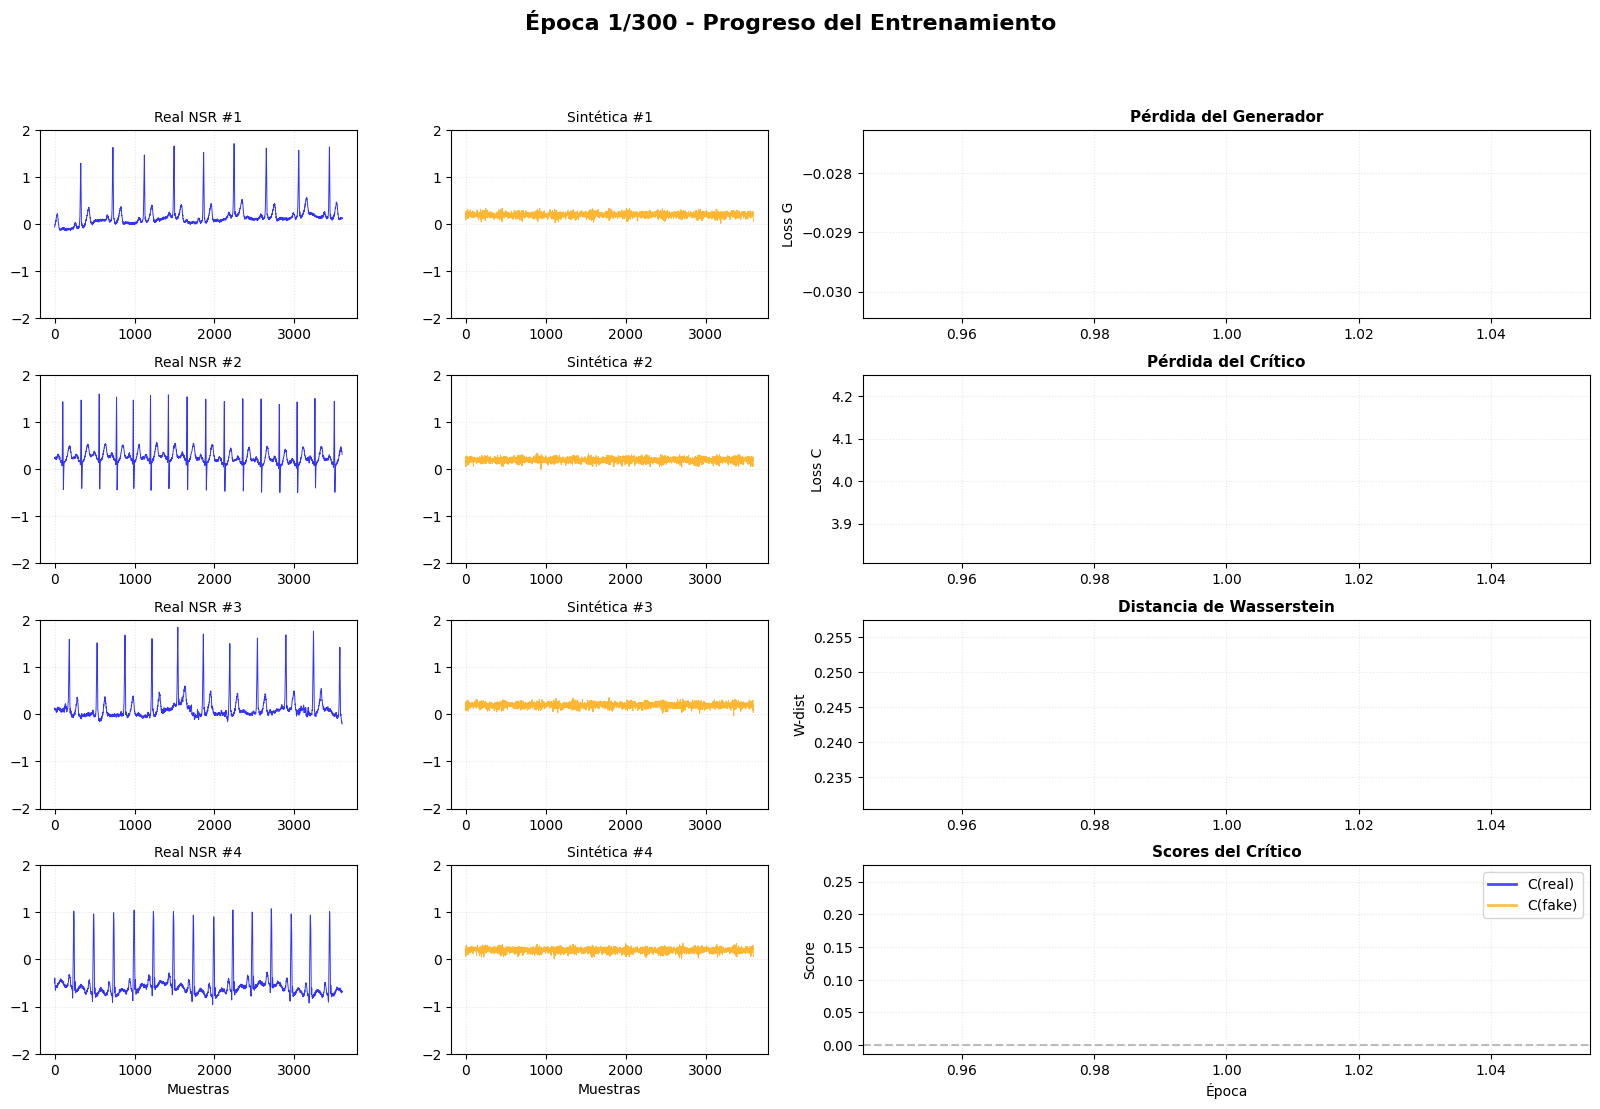


📊 Estadísticas época 1:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.032, Max:   0.355, Mean:   0.195, Std:   0.044
  Rango real: 2.805, Rango sintético: 0.386
  Separación C(real)-C(fake): 0.2440

Época [  10/300] | Loss_G:  -0.0518 | Loss_C:  -3.8494 | W_dist:   4.2337 | GP:  0.038 | C(real):   4.321 | C(fake):   0.088
Época [  20/300] | Loss_G:   2.5125 | Loss_C: -12.2358 | W_dist:  14.2686 | GP:  0.203 | C(real):  12.372 | C(fake):  -1.897
Época [  30/300] | Loss_G:  -2.9333 | Loss_C:  -5.8387 | W_dist:   7.5681 | GP:  0.173 | C(real):   9.681 | C(fake):   2.113
Época [  40/300] | Loss_G:  -2.4269 | Loss_C:  -5.9833 | W_dist:   6.6034 | GP:  0.062 | C(real):   7.700 | C(fake):   1.096
Época [  50/300] | Loss_G:   0.3990 | Loss_C:  -6.8624 | W_dist:   7.9161 | GP:  0.105 | C(real):   7.542 | C(fake):  -0.374


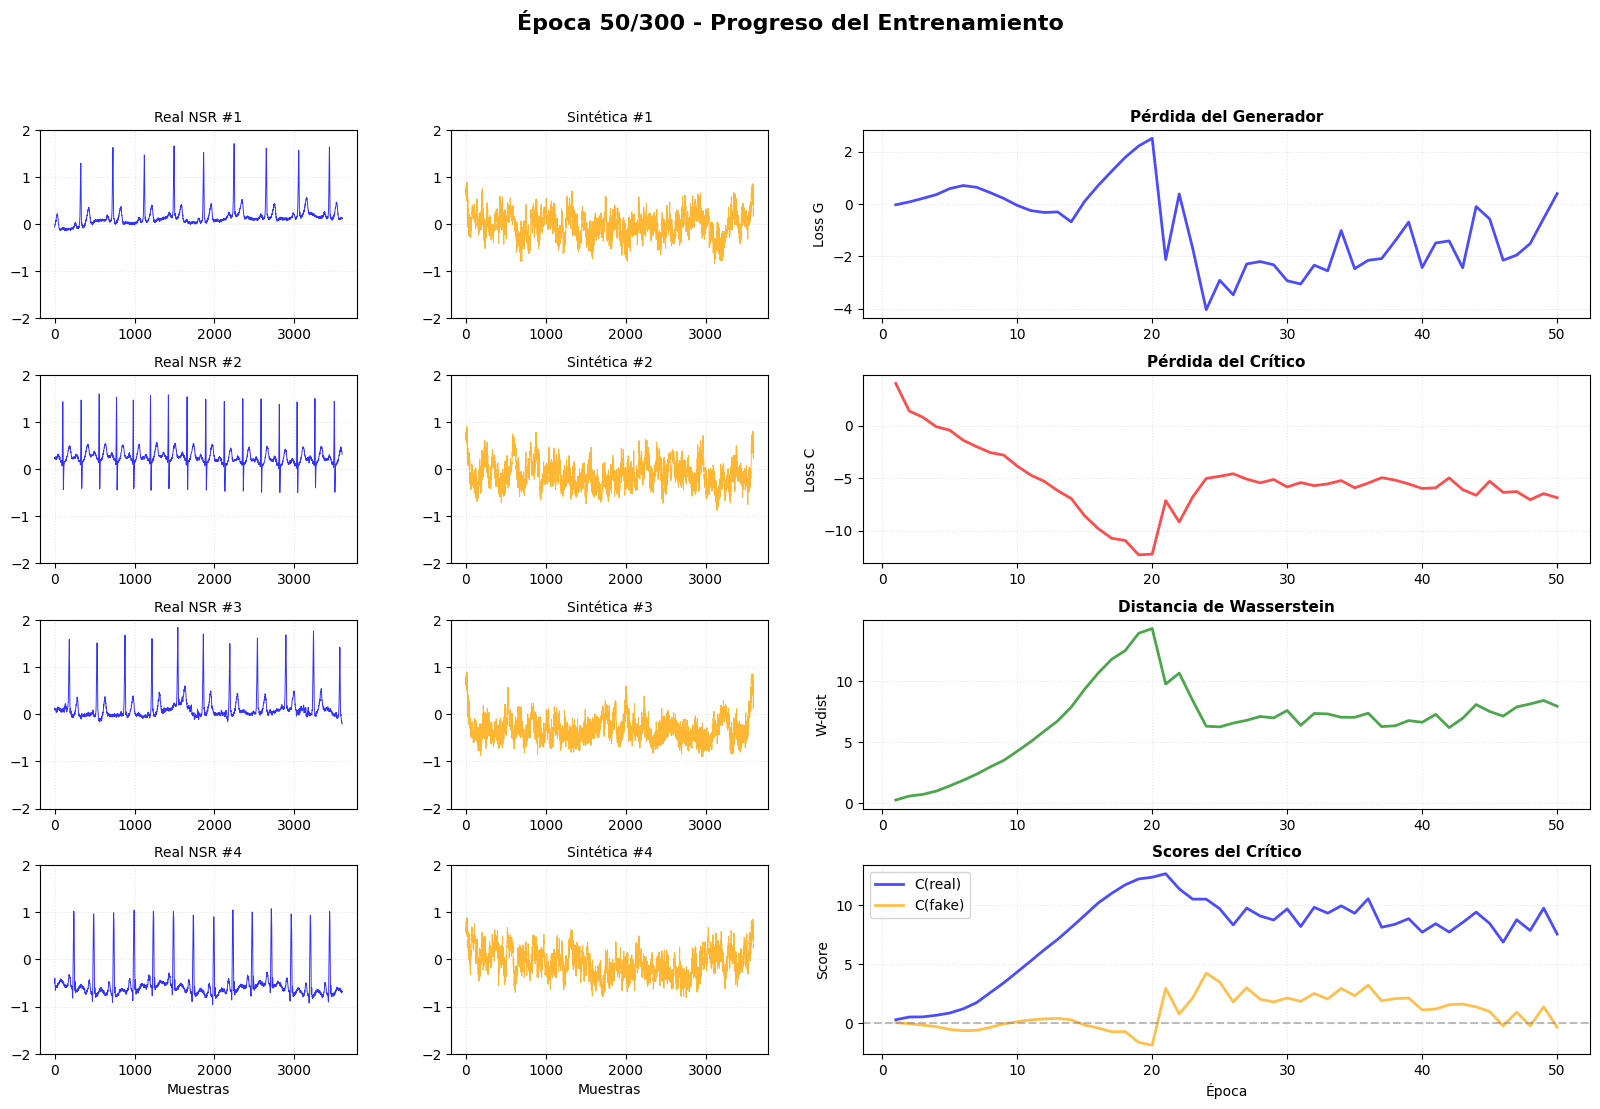


📊 Estadísticas época 50:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.902, Max:   0.905, Mean:  -0.127, Std:   0.298
  Rango real: 2.805, Rango sintético: 1.806
  Separación C(real)-C(fake): 7.9161

Época [  60/300] | Loss_G:   0.3052 | Loss_C:  -6.8806 | W_dist:   9.8757 | GP:  0.300 | C(real):  11.388 | C(fake):   1.512
Época [  70/300] | Loss_G:   1.1368 | Loss_C:  -9.7459 | W_dist:  12.3674 | GP:  0.262 | C(real):  12.710 | C(fake):   0.343
Época [  80/300] | Loss_G:   0.5920 | Loss_C: -11.0450 | W_dist:  15.8360 | GP:  0.479 | C(real):  14.597 | C(fake):  -1.239
Época [  90/300] | Loss_G:   0.1085 | Loss_C: -11.8830 | W_dist:  13.2056 | GP:  0.132 | C(real):  12.615 | C(fake):  -0.590
Época [ 100/300] | Loss_G:   0.9942 | Loss_C:  -8.2152 | W_dist:   8.8644 | GP:  0.065 | C(real):   7.737 | C(fake):  -1.127


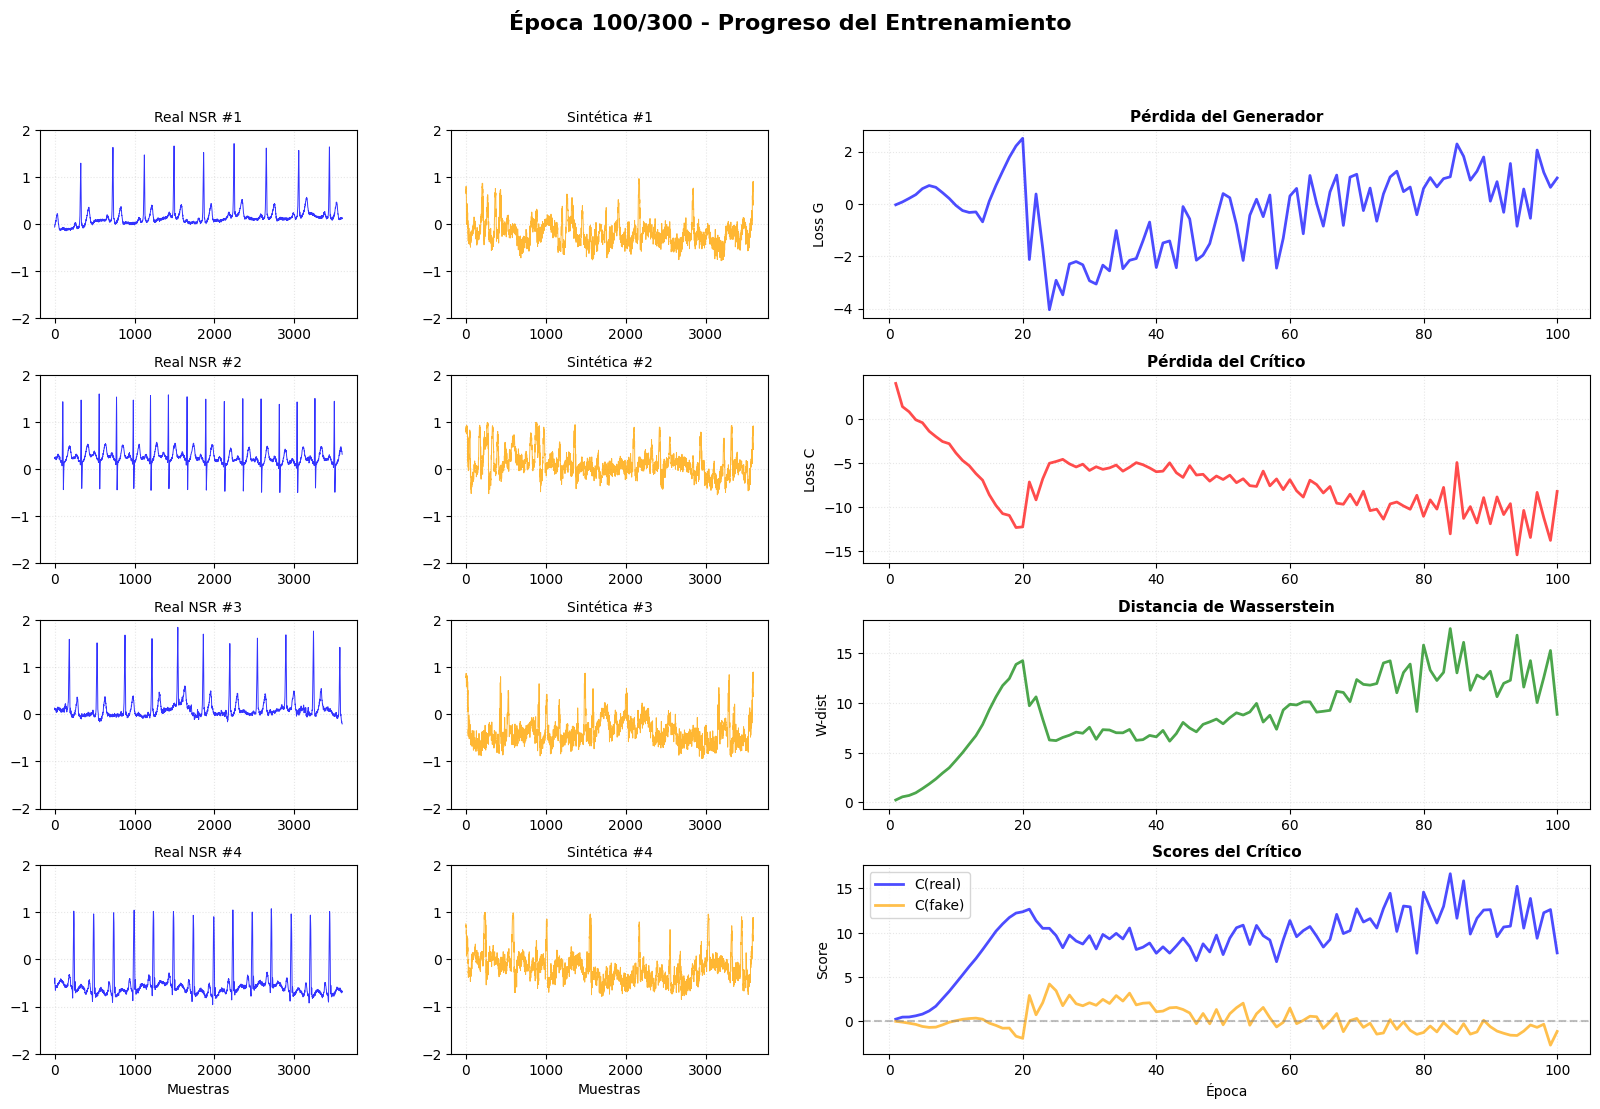


📊 Estadísticas época 100:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.941, Max:   0.995, Mean:  -0.156, Std:   0.336
  Rango real: 2.805, Rango sintético: 1.936
  Separación C(real)-C(fake): 8.8644

Época [ 110/300] | Loss_G:   2.2045 | Loss_C: -12.4001 | W_dist:  13.7237 | GP:  0.132 | C(real):  12.024 | C(fake):  -1.700
Época [ 120/300] | Loss_G:   4.3105 | Loss_C: -19.5531 | W_dist:  22.6001 | GP:  0.305 | C(real):  19.358 | C(fake):  -3.242
Época [ 130/300] | Loss_G:   5.1485 | Loss_C:  -0.9135 | W_dist:   2.6882 | GP:  0.177 | C(real):  -2.368 | C(fake):  -5.056
Época [ 140/300] | Loss_G:   3.8188 | Loss_C: -17.1871 | W_dist:  21.9549 | GP:  0.477 | C(real):  20.633 | C(fake):  -1.322
Época [ 150/300] | Loss_G:   0.2438 | Loss_C:  -9.8472 | W_dist:  18.7814 | GP:  0.893 | C(real):  20.698 | C(fake):   1.917


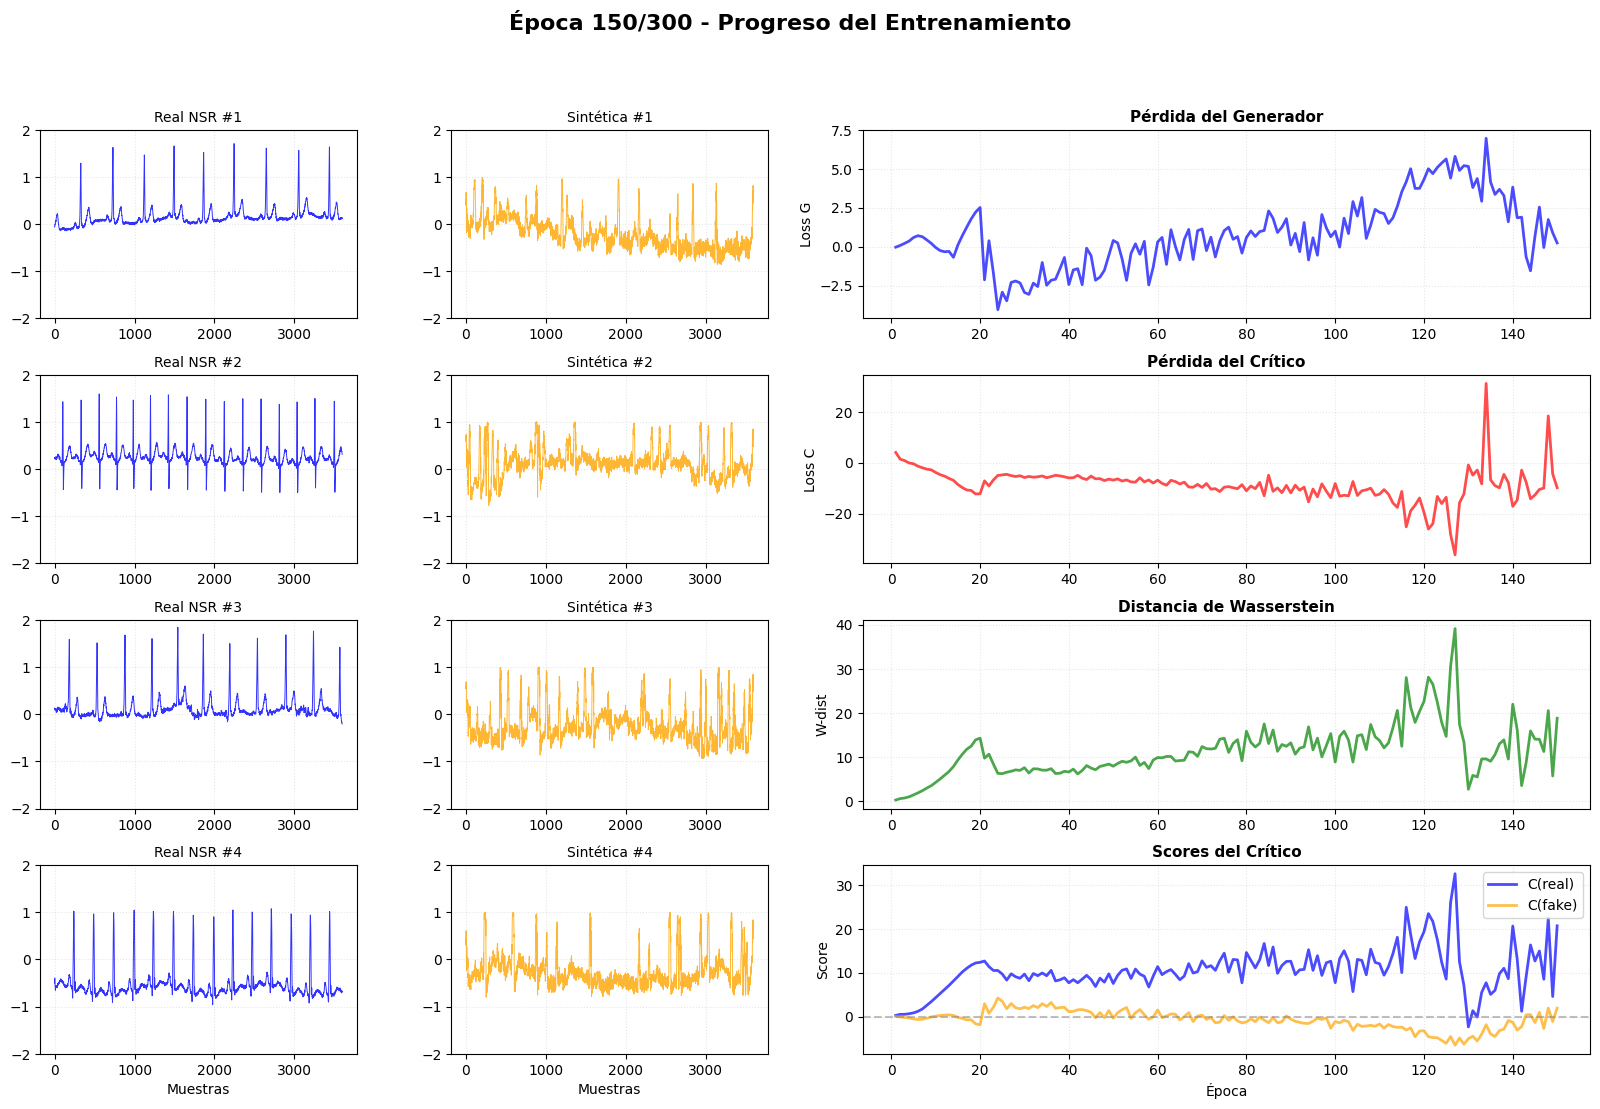


📊 Estadísticas época 150:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.939, Max:   1.000, Mean:  -0.139, Std:   0.381
  Rango real: 2.805, Rango sintético: 1.938
  Separación C(real)-C(fake): 18.7814

Época [ 160/300] | Loss_G:   1.6675 | Loss_C: -20.7443 | W_dist:  24.9147 | GP:  0.417 | C(real):  23.838 | C(fake):  -1.077
Época [ 170/300] | Loss_G:   2.6259 | Loss_C: -53.6266 | W_dist:  59.0864 | GP:  0.546 | C(real):  56.707 | C(fake):  -2.379
Época [ 180/300] | Loss_G:   4.2896 | Loss_C: -78.4245 | W_dist:  86.2846 | GP:  0.786 | C(real):  82.282 | C(fake):  -4.003
Época [ 190/300] | Loss_G:  -0.6592 | Loss_C: -13.0528 | W_dist:  16.4525 | GP:  0.340 | C(real):  16.980 | C(fake):   0.528
Época [ 200/300] | Loss_G:  -2.1451 | Loss_C: -12.8919 | W_dist:  15.5829 | GP:  0.269 | C(real):  17.255 | C(fake):   1.672


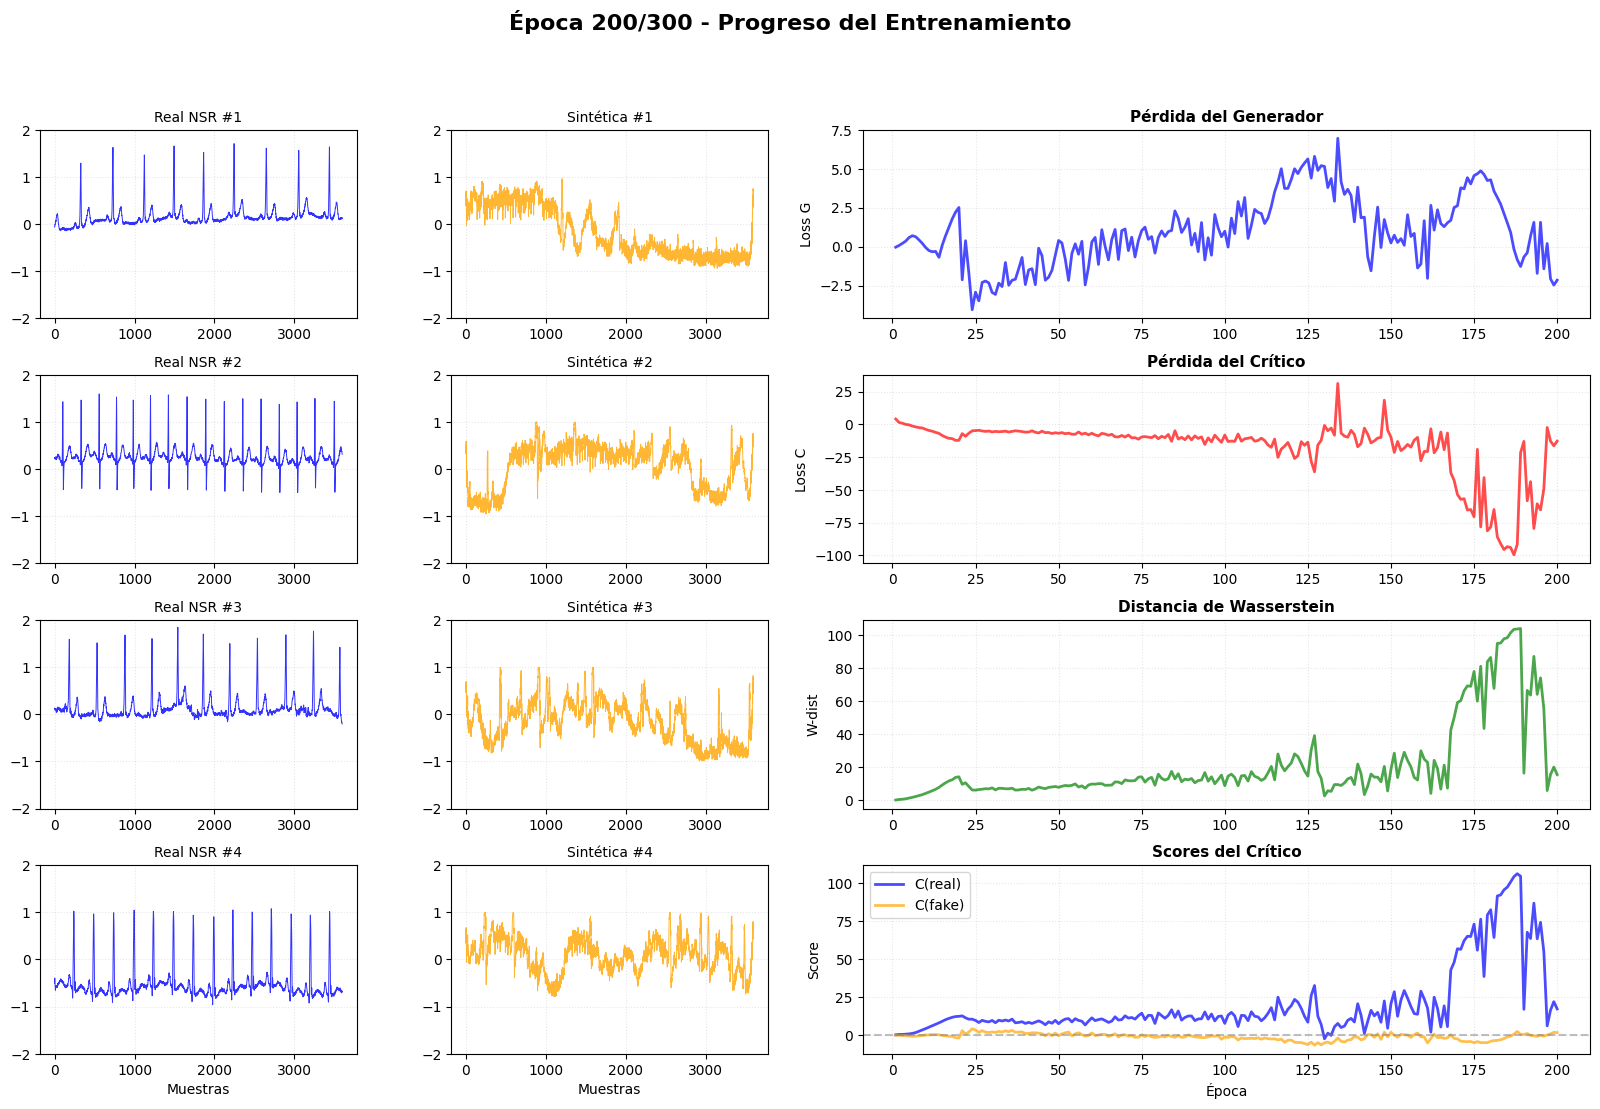


📊 Estadísticas época 200:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.987, Max:   0.999, Mean:  -0.038, Std:   0.469
  Rango real: 2.805, Rango sintético: 1.987
  Separación C(real)-C(fake): 15.5829

Época [ 210/300] | Loss_G:  -3.1743 | Loss_C:  -9.6849 | W_dist:  12.1942 | GP:  0.251 | C(real):  15.179 | C(fake):   2.985
Época [ 220/300] | Loss_G:  -4.0347 | Loss_C:  -9.3171 | W_dist:  10.4508 | GP:  0.113 | C(real):  14.070 | C(fake):   3.620
Época [ 230/300] | Loss_G:  -7.7013 | Loss_C: -33.5921 | W_dist:  40.0210 | GP:  0.643 | C(real):  46.431 | C(fake):   6.410
Época [ 240/300] | Loss_G:  -6.3569 | Loss_C: -31.7581 | W_dist:  35.8276 | GP:  0.407 | C(real):  38.693 | C(fake):   2.865
Época [ 250/300] | Loss_G:  -5.1447 | Loss_C: -17.8957 | W_dist:  22.1071 | GP:  0.421 | C(real):  28.734 | C(fake):   6.627


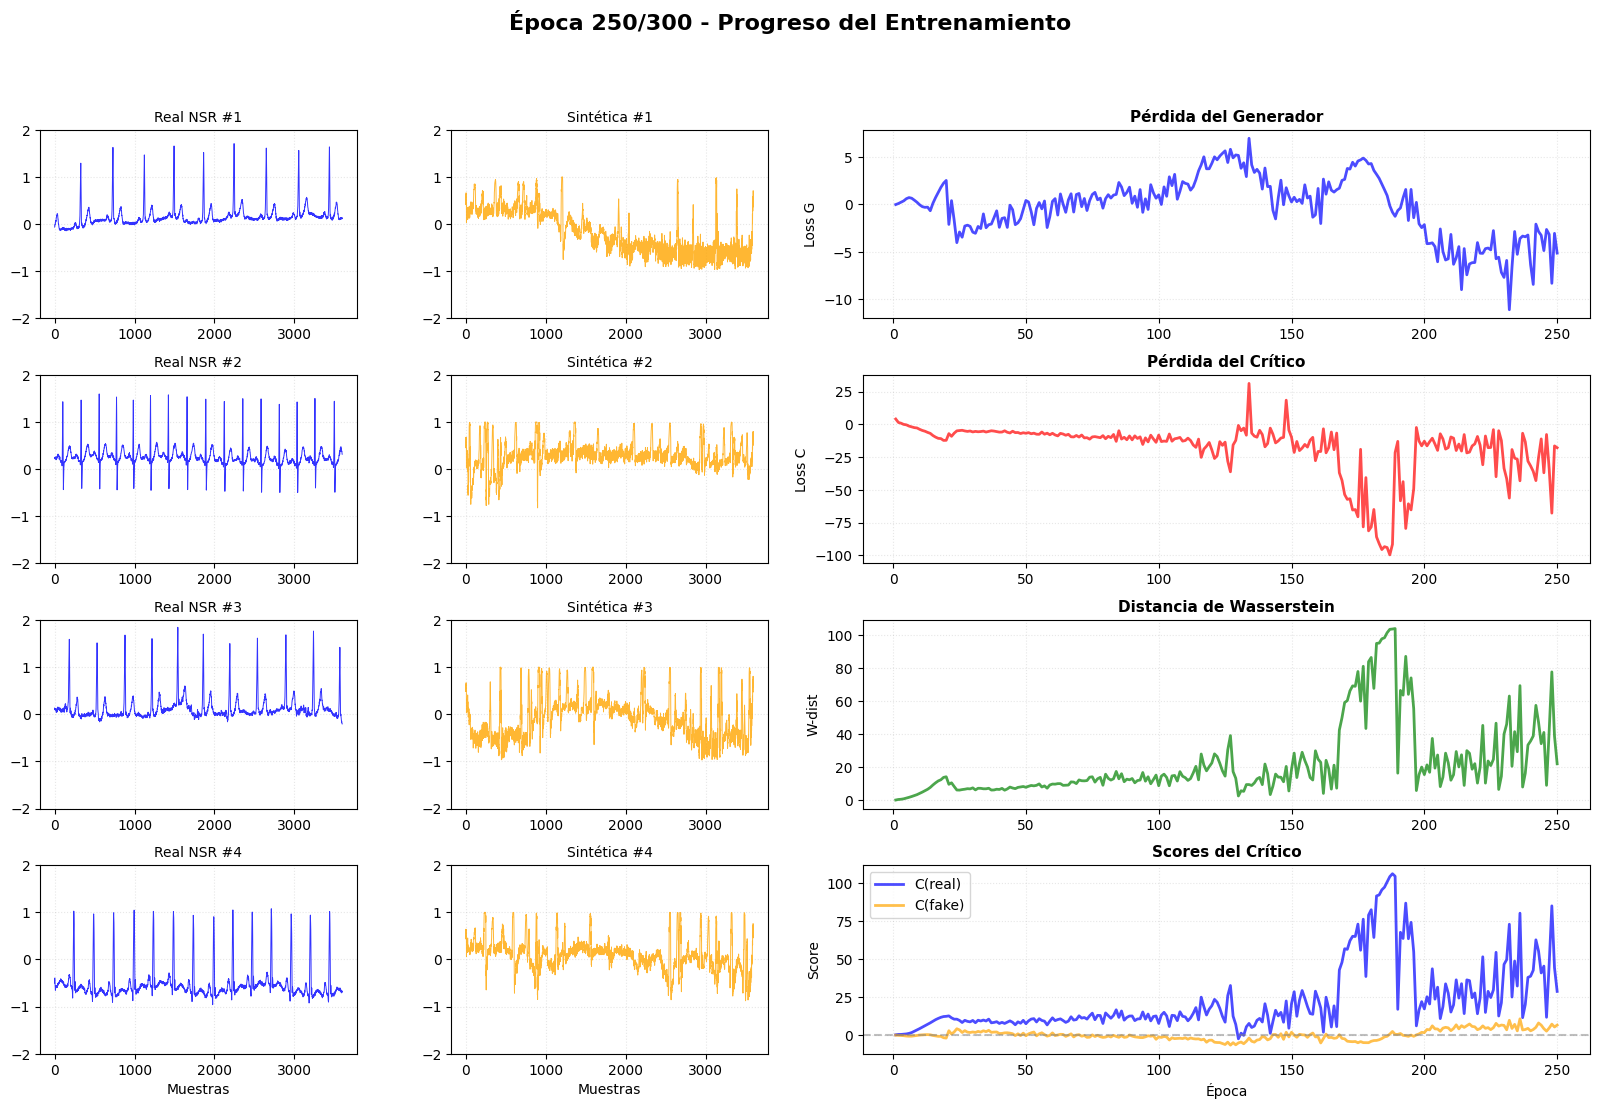


📊 Estadísticas época 250:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.970, Max:   1.000, Mean:   0.036, Std:   0.429
  Rango real: 2.805, Rango sintético: 1.970
  Separación C(real)-C(fake): 22.1071

Época [ 260/300] | Loss_G:  -6.7200 | Loss_C: -25.6904 | W_dist:  28.7038 | GP:  0.301 | C(real):  32.747 | C(fake):   4.043
Época [ 270/300] | Loss_G:  -5.8914 | Loss_C: -18.4303 | W_dist:  22.5243 | GP:  0.409 | C(real):  28.413 | C(fake):   5.889
Época [ 280/300] | Loss_G:  -5.4181 | Loss_C: -10.0169 | W_dist:  12.8432 | GP:  0.283 | C(real):  18.070 | C(fake):   5.227
Época [ 290/300] | Loss_G:  -5.0638 | Loss_C: -40.6350 | W_dist:  42.8577 | GP:  0.222 | C(real):  48.177 | C(fake):   5.319
Época [ 300/300] | Loss_G:  -5.4767 | Loss_C: 247.7410 | W_dist:  31.7936 | GP: 27.953 | C(real):  49.297 | C(fake):  17.504


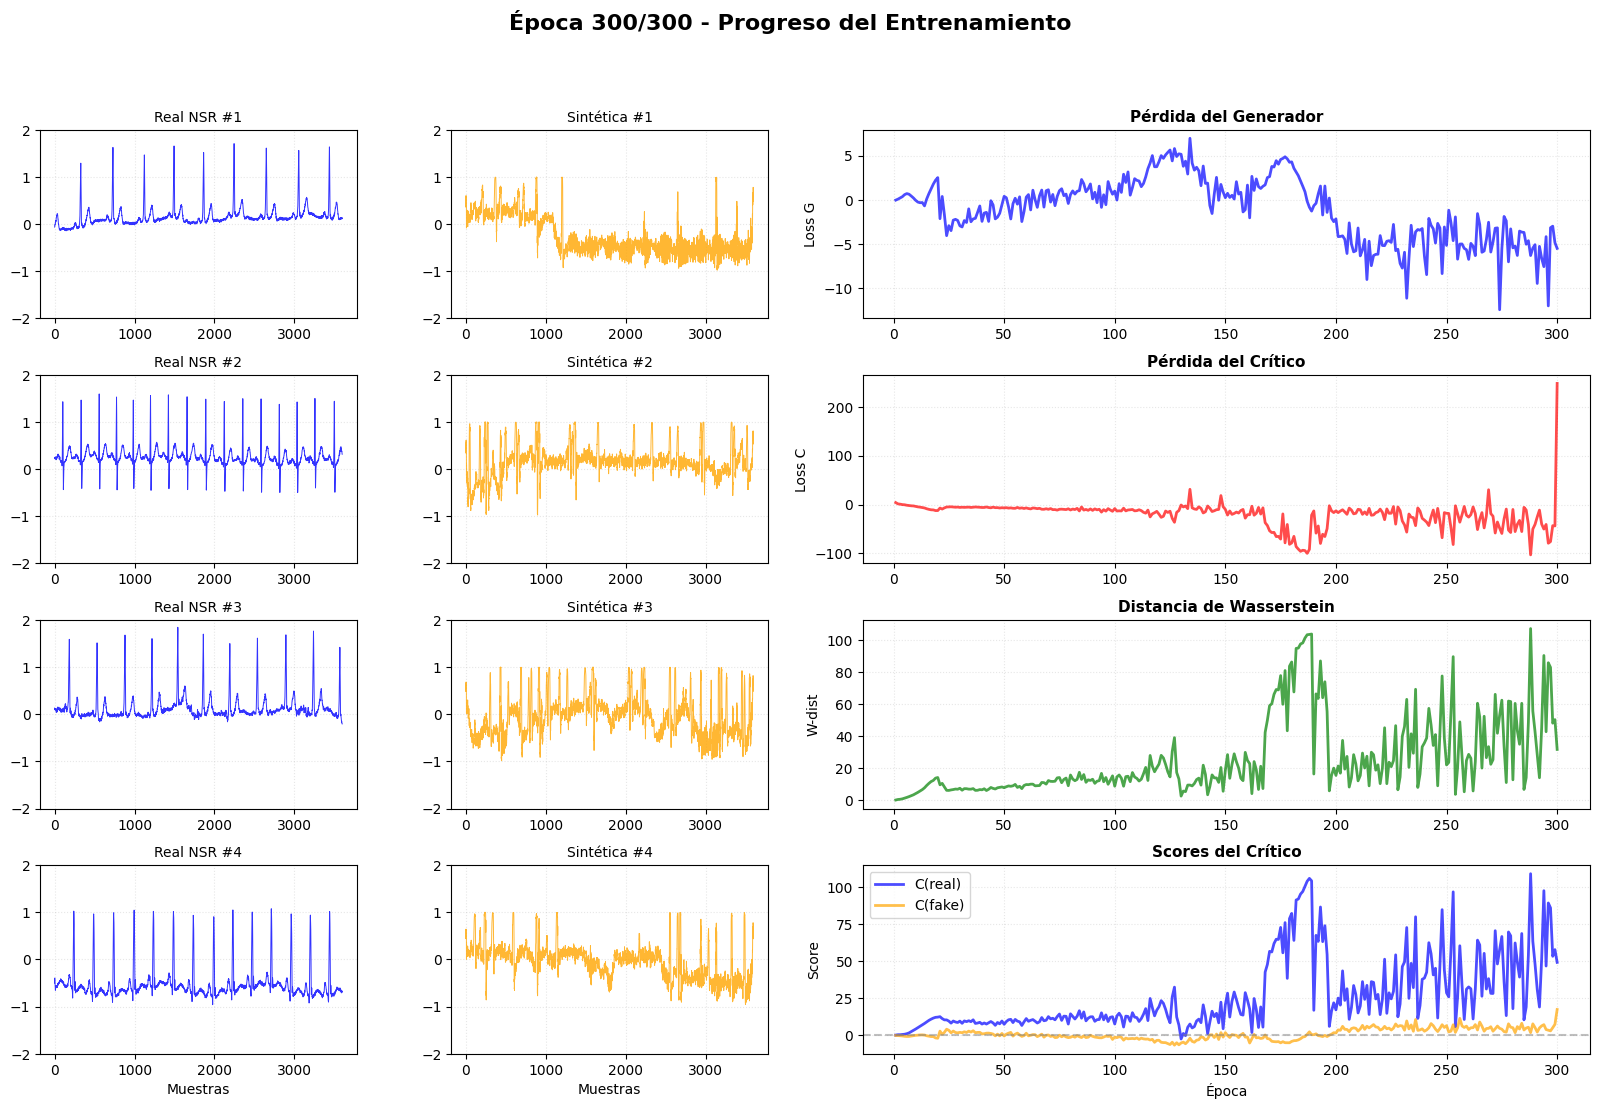


📊 Estadísticas época 300:
  Real      - Min:  -0.960, Max:   1.845, Mean:   0.008, Std:   0.414
  Sintética - Min:  -0.986, Max:   1.000, Mean:  -0.040, Std:   0.421
  Rango real: 2.805, Rango sintético: 1.986
  Separación C(real)-C(fake): 31.7936

✓ Entrenamiento completado


In [20]:
# Crear modelos y optimizadores
generator_refactored = Generator(latent_dim=latent_dim, signal_length=signal_length).to(config.device)
critic_refactored = Critic(signal_length=signal_length).to(config.device)

optimizer_G_ref = torch.optim.Adam(generator_refactored.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizer_C_ref = torch.optim.Adam(critic_refactored.parameters(), lr=0.0001, betas=(0.0, 0.9))

# Entrenar con la versión refactorizada
history_refactored = train_wgan_gp_refactored(
    generator=generator_refactored,
    critic=critic_refactored,
    dataloader=dataloader,
    optimizer_G=optimizer_G_ref,
    optimizer_C=optimizer_C_ref,
    num_epochs=300,  # Ajusta según necesites
    latent_dim=latent_dim,
    n_critic=5,
    lambda_gp=10.0,
    device=config.device,
    visualize_every=50,  # Visualización cada 50 épocas
    print_every=10       # Imprimir métricas cada 10 épocas
)

## 📈 Visualización Final de Resultados


📊 Estadísticas de señales:
  Real      - Min:  -1.275, Max:   2.380, Mean:   0.032, Std:   0.387
  Sintética - Min:  -0.997, Max:   1.000, Mean:   0.026, Std:   0.481
  Rango real: 3.655, Rango sintético: 1.997

✓ Análisis de resultados completado


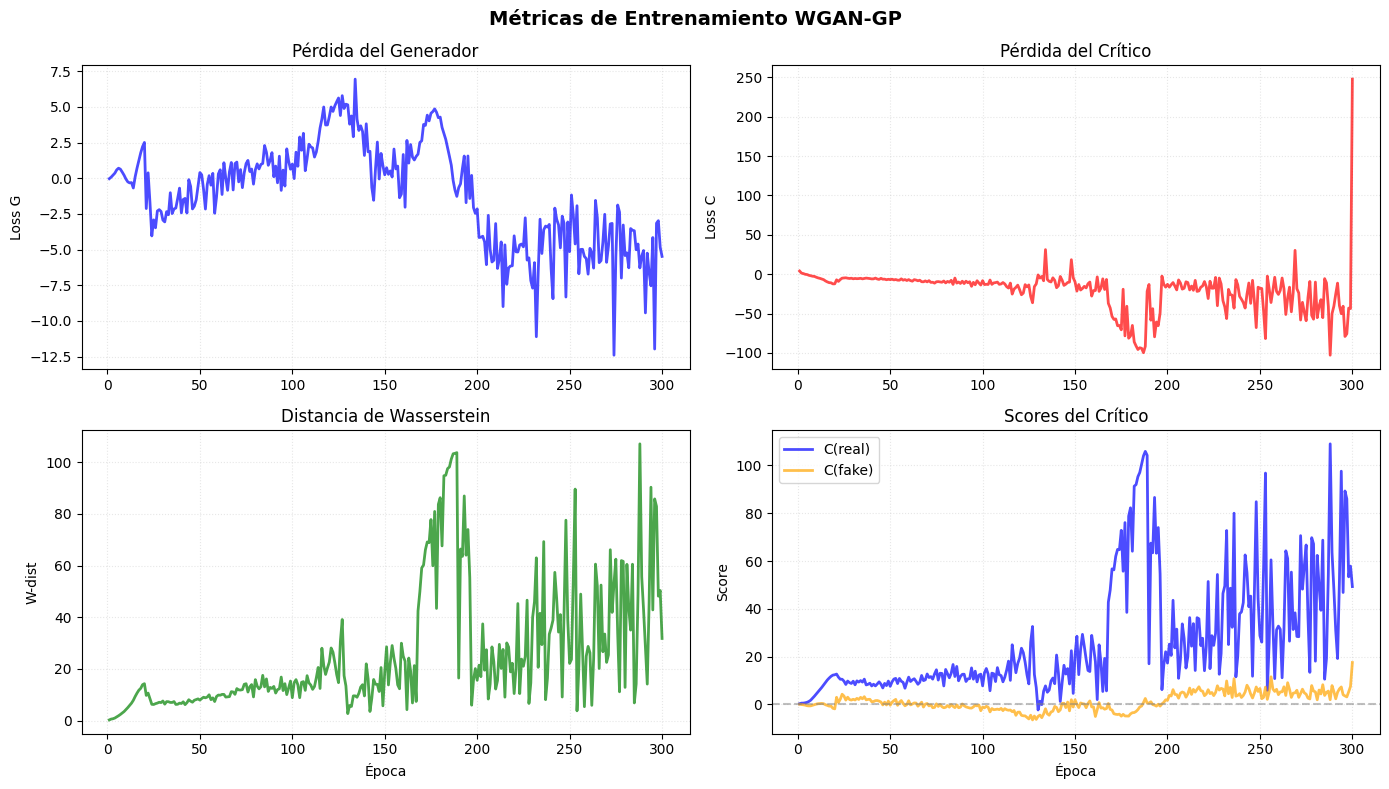

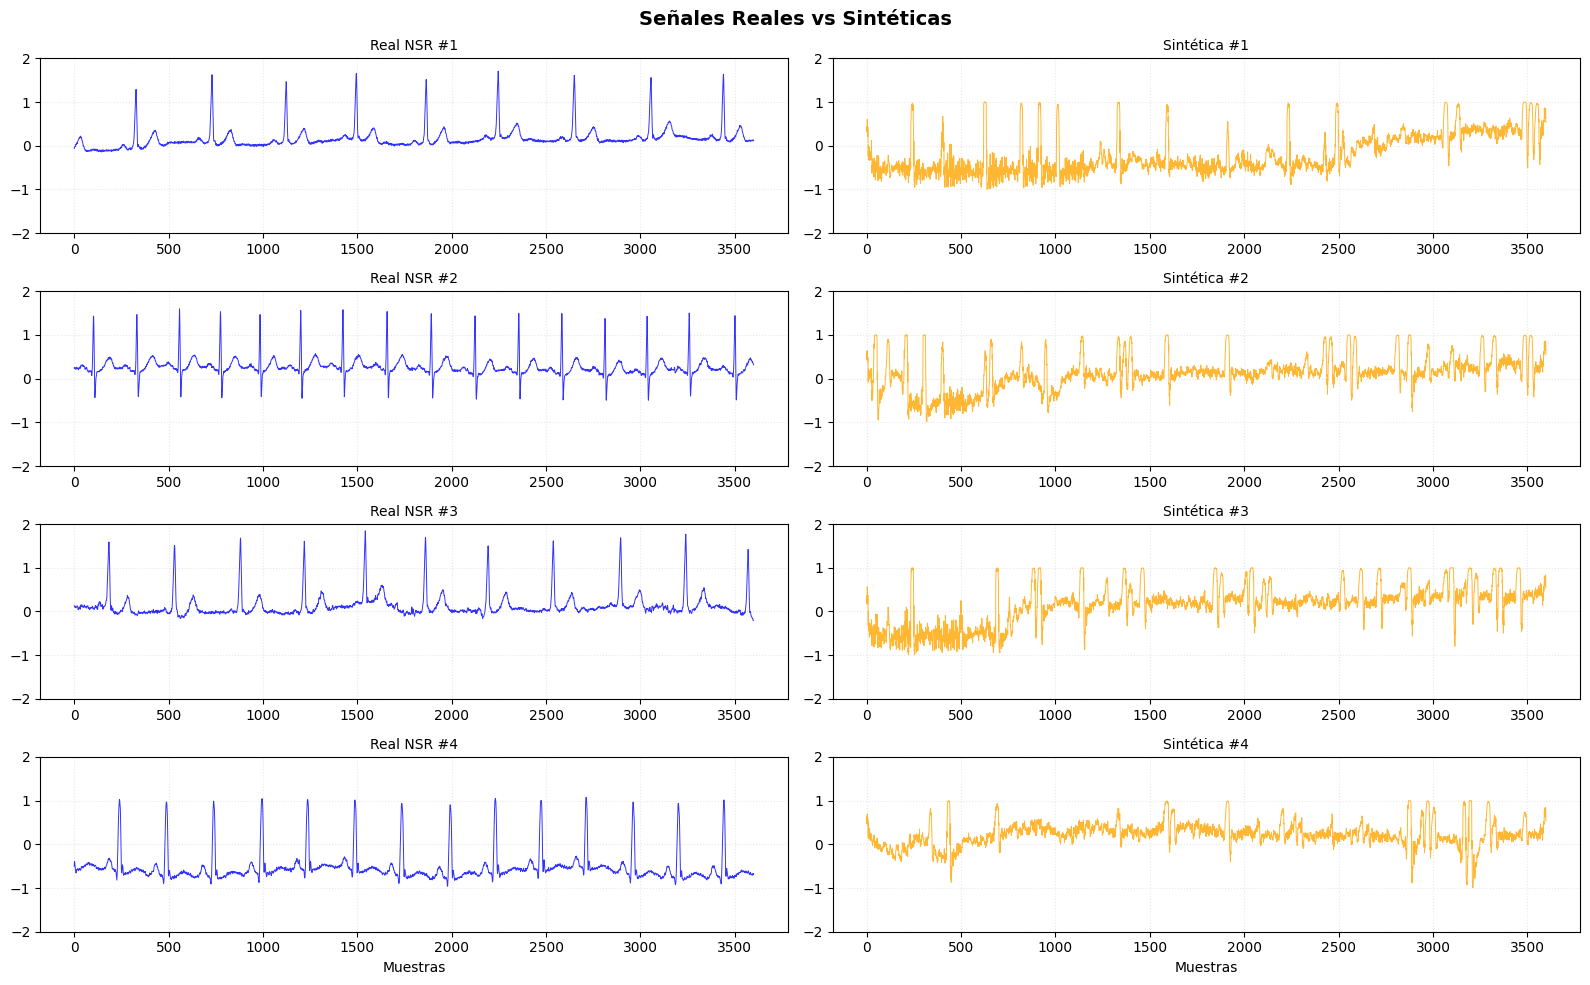

In [21]:
# Visualizar métricas de entrenamiento usando función auxiliar
plot_training_metrics(history_refactored)

# Generar y comparar señales finales
generator_refactored.eval()
with torch.no_grad():
    # Generar señales sintéticas
    test_z = torch.randn(8, latent_dim).to(config.device)
    fake_signals = generator_refactored(test_z).cpu().numpy()
    
    # Obtener señales reales
    real_signals, _ = next(iter(dataloader))
    real_signals = real_signals[:8].cpu().numpy()
    
    # Visualizar comparación usando función auxiliar
    plot_signals_comparison(real_signals, fake_signals, num_samples=4, figsize=(16, 10))
    
    # Imprimir estadísticas finales
    print_signal_statistics(real_signals, fake_signals)

generator_refactored.train()

print("\n✓ Análisis de resultados completado")

## ✨ Resumen de Mejoras en la Estructura del Código

### 🎯 Mejoras Implementadas:

#### 1. **Separación de Responsabilidades**
- `plot_signals_comparison()`: Visualiza señales reales vs sintéticas
- `plot_training_metrics()`: Muestra gráficas de pérdidas y métricas
- `print_signal_statistics()`: Imprime estadísticas comparativas
- `visualize_training_progress()`: Visualización completa durante entrenamiento

#### 2. **Función de Entrenamiento Mejorada**
- `train_wgan_gp_refactored()`: Versión modular y limpia
- Usa funciones auxiliares en lugar de código duplicado
- Mejor organización de métricas
- Parámetros configurables para visualización

#### 3. **Beneficios**
- ✅ **Código más legible**: Funciones pequeñas con propósito único
- ✅ **Reutilizable**: Funciones auxiliares pueden usarse independientemente
- ✅ **Mantenible**: Más fácil debuggear y modificar
- ✅ **Documentado**: Docstrings claros en todas las funciones
- ✅ **Flexible**: Parámetros para controlar visualización y logging

#### 4. **Cómo Usar**
```python
# Simple y directo
history = train_wgan_gp_refactored(
    generator=generator,
    critic=critic,
    dataloader=dataloader,
    optimizer_G=optimizer_G,
    optimizer_C=optimizer_C,
    num_epochs=300,
    visualize_every=50,  # Cada 50 épocas
    print_every=10       # Cada 10 épocas
)

# Visualización post-entrenamiento
plot_training_metrics(history)
plot_signals_comparison(real, fake)
```

### 📊 Visualización Durante Entrenamiento
Cada 50 épocas (configurable) verás:
- 4 señales reales vs 4 sintéticas (lado a lado)
- 4 gráficas de métricas (Loss G, Loss C, W-dist, C(real) vs C(fake))
- Estadísticas numéricas (min, max, mean, std)
- Separación del crítico C(real) - C(fake)

## Entrenar con WGAN-GP

Ahora entrenamos usando Gradient Penalty en lugar de weight clipping. Esto debería dar mejores resultados.

In [22]:
# Reinstanciar modelos y optimizadores para WGAN-GP
generator_gp = Generator(latent_dim=latent_dim, signal_length=signal_length).to(config.device)
critic_gp = Critic(signal_length=signal_length).to(config.device)

# WGAN-GP no usa weight clipping, así que no necesitamos clip_value
# Usamos learning rates ligeramente más altos
optimizer_G_gp = torch.optim.Adam(generator_gp.parameters(), lr=0.0001, betas=(0.0, 0.9))
optimizer_C_gp = torch.optim.Adam(critic_gp.parameters(), lr=0.0001, betas=(0.0, 0.9))

print("✓ Modelos WGAN-GP instanciados")
print(f"  - Gradient Penalty lambda: 10")
print(f"  - n_critic: 5")
print(f"  - Learning rate: 0.0001 (ambos)")

✓ Modelos WGAN-GP instanciados
  - Gradient Penalty lambda: 10
  - n_critic: 5
  - Learning rate: 0.0001 (ambos)


## 🎨 Técnicas para reducir el ruido

Para mejorar la calidad de las señales y reducir el ruido, aplicamos:

1. **Spectral Normalization** en el crítico: Estabiliza el entrenamiento
2. **Suavizado con convoluciones**: Filtrado de alta frecuencia en el generador
3. **Learning rate scheduling**: Reducir LR gradualmente
4. **Label smoothing**: Suavizar etiquetas del crítico
5. **Batch size menor**: 32 en lugar de 96 para mejor convergencia

In [23]:
# Crear DataLoader con batch_size más pequeño para mejor convergencia
dataloader_small = get_dataloader(label_name='NSR', batch_size=32)
print(f"✓ DataLoader creado con batch_size=32 (antes era 96)")
print(f"  Batches por época: {len(dataloader_small)}")

✓ DataLoader creado con batch_size=32 (antes era 96)
  Batches por época: 9


In [24]:
class GeneratorSmooth(nn.Module):
    """
    Generador mejorado con capas de suavizado para reducir ruido
    """
    def __init__(self, latent_dim=128, signal_length=3600):
        super(GeneratorSmooth, self).__init__()
        self.latent_dim = latent_dim
        self.signal_length = signal_length
        self.init_size = 56
        
        # Capa inicial
        self.fc = nn.Linear(latent_dim, 512 * self.init_size)
        self.bn0 = nn.BatchNorm1d(512)
        
        # Capas de convolución transpuesta
        self.conv_blocks = nn.Sequential(
            # 56 -> 112
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            # 112 -> 224
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            # 224 -> 448
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            
            # 448 -> 896
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            
            # 896 -> 1792
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            # 1792 -> 3584
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
        )
        
        # Capa de salida con suavizado
        self.output = nn.Sequential(
            nn.Conv1d(8, 4, kernel_size=17, stride=1, padding=8),
            nn.ReLU(inplace=True),
            nn.Conv1d(4, 1, kernel_size=17, stride=1, padding=8),
            nn.Tanh()
        )
        
        # Capa de suavizado adicional (filtro paso bajo)
        self.smooth = nn.Conv1d(1, 1, kernel_size=25, stride=1, padding=12, bias=False)
        # Inicializar con kernel gaussiano para suavizado
        with torch.no_grad():
            kernel = torch.exp(-torch.linspace(-3, 3, 25)**2 / 2)
            kernel = kernel / kernel.sum()
            self.smooth.weight.data = kernel.view(1, 1, -1)
            self.smooth.weight.requires_grad = False  # Mantener fijo
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 512, self.init_size)
        x = F.relu(self.bn0(x))
        x = self.conv_blocks(x)
        x = self.output(x)
        
        # Ajustar tamaño
        if x.size(2) != self.signal_length:
            x = F.interpolate(x, size=self.signal_length, mode='linear', align_corners=False)
        
        # Aplicar suavizado para reducir ruido de alta frecuencia
        x = self.smooth(x)
        
        return x

In [25]:
# Instanciar modelos mejorados con generador suavizado
generator_smooth = GeneratorSmooth(latent_dim=latent_dim, signal_length=signal_length).to(config.device)
critic_smooth = Critic(signal_length=signal_length).to(config.device)

# Optimizadores con learning rate más bajo para más estabilidad
optimizer_G_smooth = torch.optim.Adam(generator_smooth.parameters(), lr=0.00005, betas=(0.0, 0.9))
optimizer_C_smooth = torch.optim.Adam(critic_smooth.parameters(), lr=0.00005, betas=(0.0, 0.9))

# Learning rate scheduler para reducir LR gradualmente
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G_smooth, step_size=100, gamma=0.9)
scheduler_C = torch.optim.lr_scheduler.StepLR(optimizer_C_smooth, step_size=100, gamma=0.9)

print("✓ Modelos mejorados instanciados con:")
print(f"  - Generador con filtro de suavizado gaussiano")
print(f"  - Learning rate inicial: 0.00005 (más bajo para estabilidad)")
print(f"  - Batch size: 32 (mejor convergencia)")
print(f"  - LR Scheduler: reduce 10% cada 100 épocas")
print(f"\nParámetros:")
print(f"  - Generador: {sum(p.numel() for p in generator_smooth.parameters()):,}")
print(f"  - Crítico: {sum(p.numel() for p in critic_smooth.parameters()):,}")

✓ Modelos mejorados instanciados con:
  - Generador con filtro de suavizado gaussiano
  - Learning rate inicial: 0.00005 (más bajo para estabilidad)
  - Batch size: 32 (mejor convergencia)
  - LR Scheduler: reduce 10% cada 100 épocas

Parámetros:
  - Generador: 4,400,746
  - Crítico: 2,753,697


In [26]:
def train_wgan_gp_with_schedulers(generator, critic, dataloader, optimizer_G, optimizer_C,
                                 scheduler_G, scheduler_C, num_epochs=100, latent_dim=100, 
                                 n_critic=5, lambda_gp=10, device='cuda', visualize_every=50):
    """
    Entrena WGAN-GP con schedulers y visualización mejorada
    """
    
    generator.train()
    critic.train()
    
    history = {
        'loss_G': [],
        'loss_C': [],
        'W_dist': [],
        'gp': [],
        'critic_real': [],
        'critic_fake': [],
        'lr_G': [],
        'lr_C': []
    }
    
    # Vector latente fijo para visualización consistente
    fixed_z = torch.randn(4, latent_dim).to(device)
    
    # Obtener una muestra de señales reales
    real_sample, _ = next(iter(dataloader))
    real_sample = real_sample[:4].to(device)
    
    for epoch in range(num_epochs):
        epoch_loss_G = []
        epoch_loss_C = []
        epoch_W_dist = []
        epoch_gp = []
        epoch_critic_real = []
        epoch_critic_fake = []
        
        for batch_idx, (real_signals, _) in enumerate(dataloader):
            real_signals = real_signals.to(device)
            batch_size = real_signals.size(0)
            
            # ==================== Entrenar Crítico ====================
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_signals = generator(z).detach()
                
                critic_real = critic(real_signals)
                critic_fake = critic(fake_signals)
                
                gradient_penalty = compute_gradient_penalty(
                    critic, real_signals, fake_signals, device
                )
                
                loss_C = -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gradient_penalty
                
                loss_C.backward()
                optimizer_C.step()
            
            # ==================== Entrenar Generador ====================
            optimizer_G.zero_grad()
            
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_signals = generator(z)
            
            critic_fake_g = critic(fake_signals)
            loss_G = -torch.mean(critic_fake_g)
            
            loss_G.backward()
            optimizer_G.step()
            
            # Guardar métricas
            epoch_loss_G.append(loss_G.item())
            epoch_loss_C.append(loss_C.item())
            epoch_gp.append(gradient_penalty.item())
            epoch_critic_real.append(torch.mean(critic_real).item())
            epoch_critic_fake.append(torch.mean(critic_fake).item())
            
            W_dist = torch.mean(critic_real).item() - torch.mean(critic_fake).item()
            epoch_W_dist.append(W_dist)
        
        # Actualizar learning rates
        scheduler_G.step()
        scheduler_C.step()
        
        # Promediar métricas
        avg_loss_G = np.mean(epoch_loss_G)
        avg_loss_C = np.mean(epoch_loss_C)
        avg_W_dist = np.mean(epoch_W_dist)
        avg_gp = np.mean(epoch_gp)
        avg_critic_real = np.mean(epoch_critic_real)
        avg_critic_fake = np.mean(epoch_critic_fake)
        
        history['loss_G'].append(avg_loss_G)
        history['loss_C'].append(avg_loss_C)
        history['W_dist'].append(avg_W_dist)
        history['gp'].append(avg_gp)
        history['critic_real'].append(avg_critic_real)
        history['critic_fake'].append(avg_critic_fake)
        history['lr_G'].append(optimizer_G.param_groups[0]['lr'])
        history['lr_C'].append(optimizer_C.param_groups[0]['lr'])
        
        # Imprimir progreso
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Época [{epoch+1:3d}/{num_epochs}] | "
                  f"Loss_G: {avg_loss_G:7.4f} | Loss_C: {avg_loss_C:7.4f} | "
                  f"W_dist: {avg_W_dist:7.4f} | GP: {avg_gp:6.3f} | "
                  f"C(real): {avg_critic_real:6.3f} | C(fake): {avg_critic_fake:6.3f} | "
                  f"LR: {optimizer_G.param_groups[0]['lr']:.6f}")
        
        # ==================== VISUALIZACIÓN ====================
        if (epoch + 1) % visualize_every == 0 or epoch == 0:
            generator.eval()
            with torch.no_grad():
                fake_vis = generator(fixed_z).cpu().numpy()
                real_vis = real_sample.cpu().numpy()
                
                fig = plt.figure(figsize=(20, 12))
                gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
                
                fig.suptitle(f'Época {epoch+1}/{num_epochs} - WGAN-GP con Suavizado', 
                           fontsize=16, fontweight='bold')
                
                # Señales
                for i in range(4):
                    ax_real = fig.add_subplot(gs[i, 0])
                    ax_real.plot(real_vis[i, 0, :], color='blue', alpha=0.8, linewidth=0.7)
                    ax_real.set_title(f'Real #{i+1}', fontsize=10)
                    ax_real.set_ylim(-2, 2)
                    ax_real.grid(ls=':', alpha=0.3)
                    if i == 3:
                        ax_real.set_xlabel('Muestras')
                    
                    ax_fake = fig.add_subplot(gs[i, 1])
                    ax_fake.plot(fake_vis[i, 0, :], color='orange', alpha=0.8, linewidth=0.7)
                    ax_fake.set_title(f'Sintética #{i+1}', fontsize=10)
                    ax_fake.set_ylim(-2, 2)
                    ax_fake.grid(ls=':', alpha=0.3)
                    if i == 3:
                        ax_fake.set_xlabel('Muestras')
                
                epochs_so_far = list(range(1, epoch + 2))
                
                # Gráficas
                ax1 = fig.add_subplot(gs[0, 2:])
                ax1.plot(epochs_so_far, history['loss_G'], 'b-', linewidth=2)
                ax1.set_title('Loss Generator', fontsize=11, fontweight='bold')
                ax1.set_ylabel('Loss')
                ax1.grid(ls=':', alpha=0.3)
                
                ax2 = fig.add_subplot(gs[1, 2:])
                ax2.plot(epochs_so_far, history['loss_C'], 'r-', linewidth=2)
                ax2.set_title('Loss Critic', fontsize=11, fontweight='bold')
                ax2.set_ylabel('Loss')
                ax2.grid(ls=':', alpha=0.3)
                
                ax3 = fig.add_subplot(gs[2, 2:])
                ax3.plot(epochs_so_far, history['W_dist'], 'g-', linewidth=2)
                ax3.set_title('Wasserstein Distance', fontsize=11, fontweight='bold')
                ax3.set_ylabel('Distance')
                ax3.grid(ls=':', alpha=0.3)
                
                ax4 = fig.add_subplot(gs[3, 2:])
                ax4.plot(epochs_so_far, history['critic_real'], 'b-', linewidth=2, label='C(real)')
                ax4.plot(epochs_so_far, history['critic_fake'], 'orange', linewidth=2, label='C(fake)')
                ax4.set_title('Critic Scores', fontsize=11, fontweight='bold')
                ax4.set_xlabel('Época')
                ax4.set_ylabel('Score')
                ax4.legend()
                ax4.grid(ls=':', alpha=0.3)
                ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                
                plt.show()
                
                print(f"\n📊 Estadísticas época {epoch+1}:")
                print(f"  Real:      Min={real_vis.min():.3f}, Max={real_vis.max():.3f}, "
                      f"Mean={real_vis.mean():.3f}, Std={real_vis.std():.3f}")
                print(f"  Sintética: Min={fake_vis.min():.3f}, Max={fake_vis.max():.3f}, "
                      f"Mean={fake_vis.mean():.3f}, Std={fake_vis.std():.3f}")
                print(f"  Separación: {avg_critic_real - avg_critic_fake:.4f}")
                print(f"  Learning Rate: {optimizer_G.param_groups[0]['lr']:.6f}\n")
            
            generator.train()
    
    return history

## 🚀 Entrenar WGAN-GP con Control de Ruido

Entrenamos con todas las mejoras aplicadas:
- ✅ Generador con filtro de suavizado
- ✅ Batch size reducido (32)
- ✅ Learning rate más bajo
- ✅ Schedulers para reducir LR gradualmente
- ✅ Visualización cada 50 épocas

In [27]:
torch.cuda.get_device_name()

'NVIDIA RTX A6000'

In [28]:
# Entrenar con visualización cada 50 épocas
print("🚀 Iniciando entrenamiento con control de ruido...")
#print(f"   GPU: {device}")
print(f"   Batch size: 32")
print(f"   Learning rate: 0.00005")
print(f"   Épocas: 300")
print(f"   Visualización cada: 50 épocas\n")

history = train_wgan_gp_with_schedulers(
    generator=generator_smooth,
    critic=critic_smooth,
    dataloader=dataloader_small,
    optimizer_G=optimizer_G_smooth,
    optimizer_C=optimizer_C_smooth,
    scheduler_G=scheduler_G_smooth,
    scheduler_C=scheduler_C_smooth,
    num_epochs=300,
    device=device,
    lambda_gp=10.0,
    visualize_every=50
)

🚀 Iniciando entrenamiento con control de ruido...
   Batch size: 32
   Learning rate: 0.00005
   Épocas: 300
   Visualización cada: 50 épocas



NameError: name 'scheduler_G_smooth' is not defined

## 📊 Gráficas finales de entrenamiento

Visualizamos el progreso completo del entrenamiento:

In [ ]:
# Gráficas completas del entrenamiento
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Progreso Completo del Entrenamiento WGAN-GP', fontsize=16, fontweight='bold')

# Loss del Crítico
axes[0, 0].plot(history['critic_losses'], label='Critic Loss', color='red', alpha=0.7)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Pérdida del Crítico')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss del Generador
axes[0, 1].plot(history['generator_losses'], label='Generator Loss', color='blue', alpha=0.7)
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Pérdida del Generador')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wasserstein Distance
axes[0, 2].plot(history['wasserstein_distances'], label='W-Distance', color='green', alpha=0.7)
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('Distancia')
axes[0, 2].set_title('Distancia de Wasserstein')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Gradient Penalty
axes[1, 0].plot(history['gradient_penalties'], label='Gradient Penalty', color='purple', alpha=0.7)
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Penalty')
axes[1, 0].set_title('Gradient Penalty')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# C(real) vs C(fake)
axes[1, 1].plot(history['critic_real'], label='C(real)', color='green', alpha=0.7)
axes[1, 1].plot(history['critic_fake'], label='C(fake)', color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Evaluación del Crítico')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 2].plot(history['lr_G'], label='LR Generator', color='blue', alpha=0.7)
axes[1, 2].plot(history['lr_C'], label='LR Critic', color='red', alpha=0.7)
axes[1, 2].set_xlabel('Época')
axes[1, 2].set_ylabel('Learning Rate')
axes[1, 2].set_title('Learning Rate Schedule')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n📊 Estadísticas finales:")
print(f"   W-Distance promedio últimas 50 épocas: {np.mean(history['wasserstein_distances'][-50:]):.4f}")
print(f"   GP promedio últimas 50 épocas: {np.mean(history['gradient_penalties'][-50:]):.4f}")
print(f"   C(real) promedio últimas 50 épocas: {np.mean(history['critic_real'][-50:]):.4f}")
print(f"   C(fake) promedio últimas 50 épocas: {np.mean(history['critic_fake'][-50:]):.4f}")

In [ ]:
# Entrenar con WGAN-GP
num_epochs_gp = 300  # Entrenar por más épocas para mejor calidad

print("Iniciando entrenamiento WGAN-GP (Gradient Penalty)...")
print(f"Device: {config.device}")
print(f"Épocas: {num_epochs_gp}")
print(f"Batch size: {dataloader.batch_size}")
print(f"Lambda GP: 10")
print("=" * 80)

start_time = time.time()

history_gp = train_wgan_gp(
    generator=generator_gp,
    critic=critic_gp,
    dataloader=dataloader,
    optimizer_G=optimizer_G_gp,
    optimizer_C=optimizer_C_gp,
    num_epochs=num_epochs_gp,
    latent_dim=latent_dim,
    n_critic=5,
    lambda_gp=10,
    device=config.device
)

elapsed_time = time.time() - start_time
print("=" * 80)
print(f"✓ Entrenamiento WGAN-GP completado en {elapsed_time/60:.2f} minutos")
print(f"  Pérdida final Generator: {history_gp['loss_G'][-1]:.4f}")
print(f"  Pérdida final Critic: {history_gp['loss_C'][-1]:.4f}")
print(f"  Wasserstein distance final: {history_gp['W_dist'][-1]:.4f}")
print(f"  Gradient Penalty final: {history_gp['gp'][-1]:.4f}")

Iniciando entrenamiento WGAN-GP (Gradient Penalty)...
Device: cuda:0
Épocas: 300
Batch size: 96
Lambda GP: 10
Época [  1/300] | Loss_G: -0.0496 | Loss_C:  3.8593 | W_dist:  0.0392 | GP:  0.390 | C(real):  0.106 | C(fake):  0.067
Época [  1/300] | Loss_G: -0.0496 | Loss_C:  3.8593 | W_dist:  0.0392 | GP:  0.390 | C(real):  0.106 | C(fake):  0.067
Época [ 10/300] | Loss_G: -0.5113 | Loss_C: -3.3518 | W_dist:  3.9739 | GP:  0.062 | C(real):  4.248 | C(fake):  0.274
Época [ 10/300] | Loss_G: -0.5113 | Loss_C: -3.3518 | W_dist:  3.9739 | GP:  0.062 | C(real):  4.248 | C(fake):  0.274
Época [ 20/300] | Loss_G:  0.4458 | Loss_C: -11.0382 | W_dist: 12.3421 | GP:  0.130 | C(real): 12.003 | C(fake): -0.339
Época [ 20/300] | Loss_G:  0.4458 | Loss_C: -11.0382 | W_dist: 12.3421 | GP:  0.130 | C(real): 12.003 | C(fake): -0.339
Época [ 30/300] | Loss_G: -3.0181 | Loss_C: -5.3700 | W_dist:  6.7107 | GP:  0.134 | C(real):  9.515 | C(fake):  2.805
Época [ 30/300] | Loss_G: -3.0181 | Loss_C: -5.3700 | W

## Visualización WGAN-GP

Visualizamos las métricas de entrenamiento con Gradient Penalty.

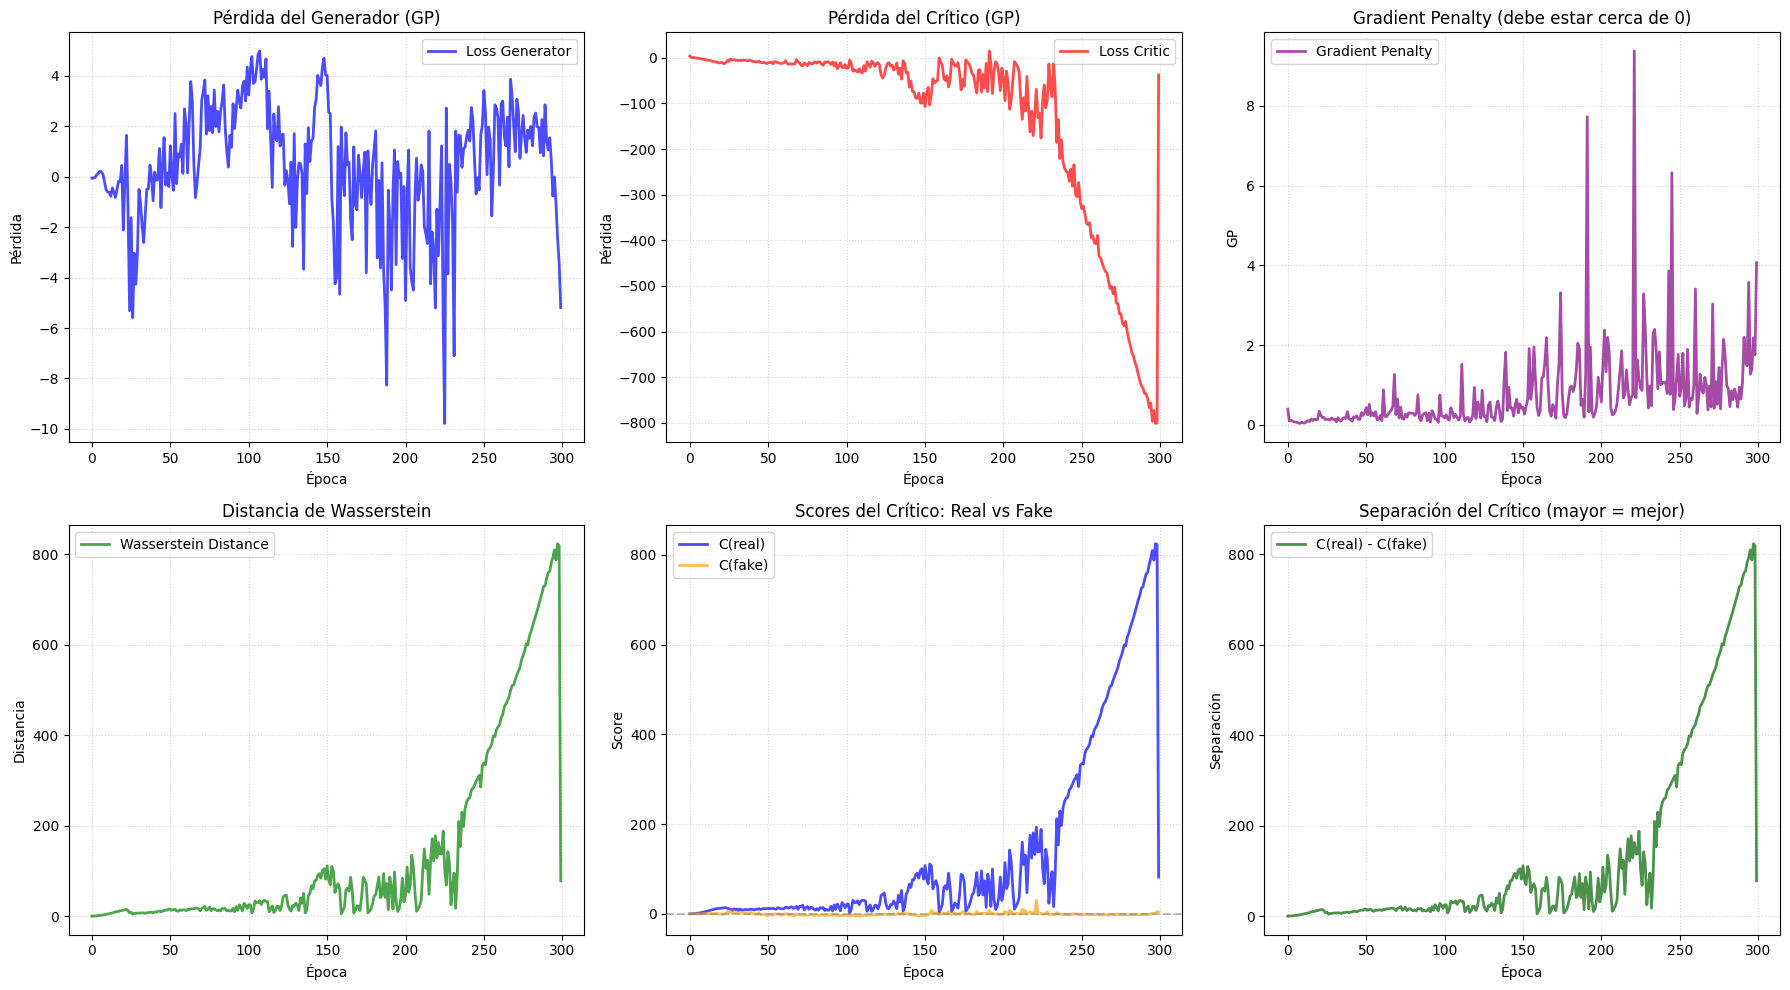


📊 Métricas finales:
  - Separación C(real)-C(fake): 78.1643
  - Gradient Penalty: 4.0670
  - Wasserstein Distance: 78.1643


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Pérdida del Generador
axes[0, 0].plot(history_gp['loss_G'], label='Loss Generator', color='blue', alpha=0.7, linewidth=2)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida')
axes[0, 0].set_title('Pérdida del Generador (GP)')
axes[0, 0].grid(ls=':', alpha=0.5)
axes[0, 0].legend()

# Pérdida del Crítico
axes[0, 1].plot(history_gp['loss_C'], label='Loss Critic', color='red', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Pérdida')
axes[0, 1].set_title('Pérdida del Crítico (GP)')
axes[0, 1].grid(ls=':', alpha=0.5)
axes[0, 1].legend()

# Gradient Penalty
axes[0, 2].plot(history_gp['gp'], label='Gradient Penalty', color='purple', alpha=0.7, linewidth=2)
axes[0, 2].set_xlabel('Época')
axes[0, 2].set_ylabel('GP')
axes[0, 2].set_title('Gradient Penalty (debe estar cerca de 0)')
axes[0, 2].grid(ls=':', alpha=0.5)
axes[0, 2].legend()

# Distancia de Wasserstein
axes[1, 0].plot(history_gp['W_dist'], label='Wasserstein Distance', color='green', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Distancia')
axes[1, 0].set_title('Distancia de Wasserstein')
axes[1, 0].grid(ls=':', alpha=0.5)
axes[1, 0].legend()

# Scores del Crítico (Real vs Fake)
axes[1, 1].plot(history_gp['critic_real'], label='C(real)', color='blue', alpha=0.7, linewidth=2)
axes[1, 1].plot(history_gp['critic_fake'], label='C(fake)', color='orange', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Scores del Crítico: Real vs Fake')
axes[1, 1].grid(ls=':', alpha=0.5)
axes[1, 1].legend()
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Separación entre C(real) y C(fake)
separation = np.array(history_gp['critic_real']) - np.array(history_gp['critic_fake'])
axes[1, 2].plot(separation, label='C(real) - C(fake)', color='darkgreen', alpha=0.7, linewidth=2)
axes[1, 2].set_xlabel('Época')
axes[1, 2].set_ylabel('Separación')
axes[1, 2].set_title('Separación del Crítico (mayor = mejor)')
axes[1, 2].grid(ls=':', alpha=0.5)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Métricas finales:")
print(f"  - Separación C(real)-C(fake): {separation[-1]:.4f}")
print(f"  - Gradient Penalty: {history_gp['gp'][-1]:.4f}")
print(f"  - Wasserstein Distance: {history_gp['W_dist'][-1]:.4f}")

## Generar señales con WGAN-GP

Usamos el generador mejorado con GP para crear señales sintéticas.

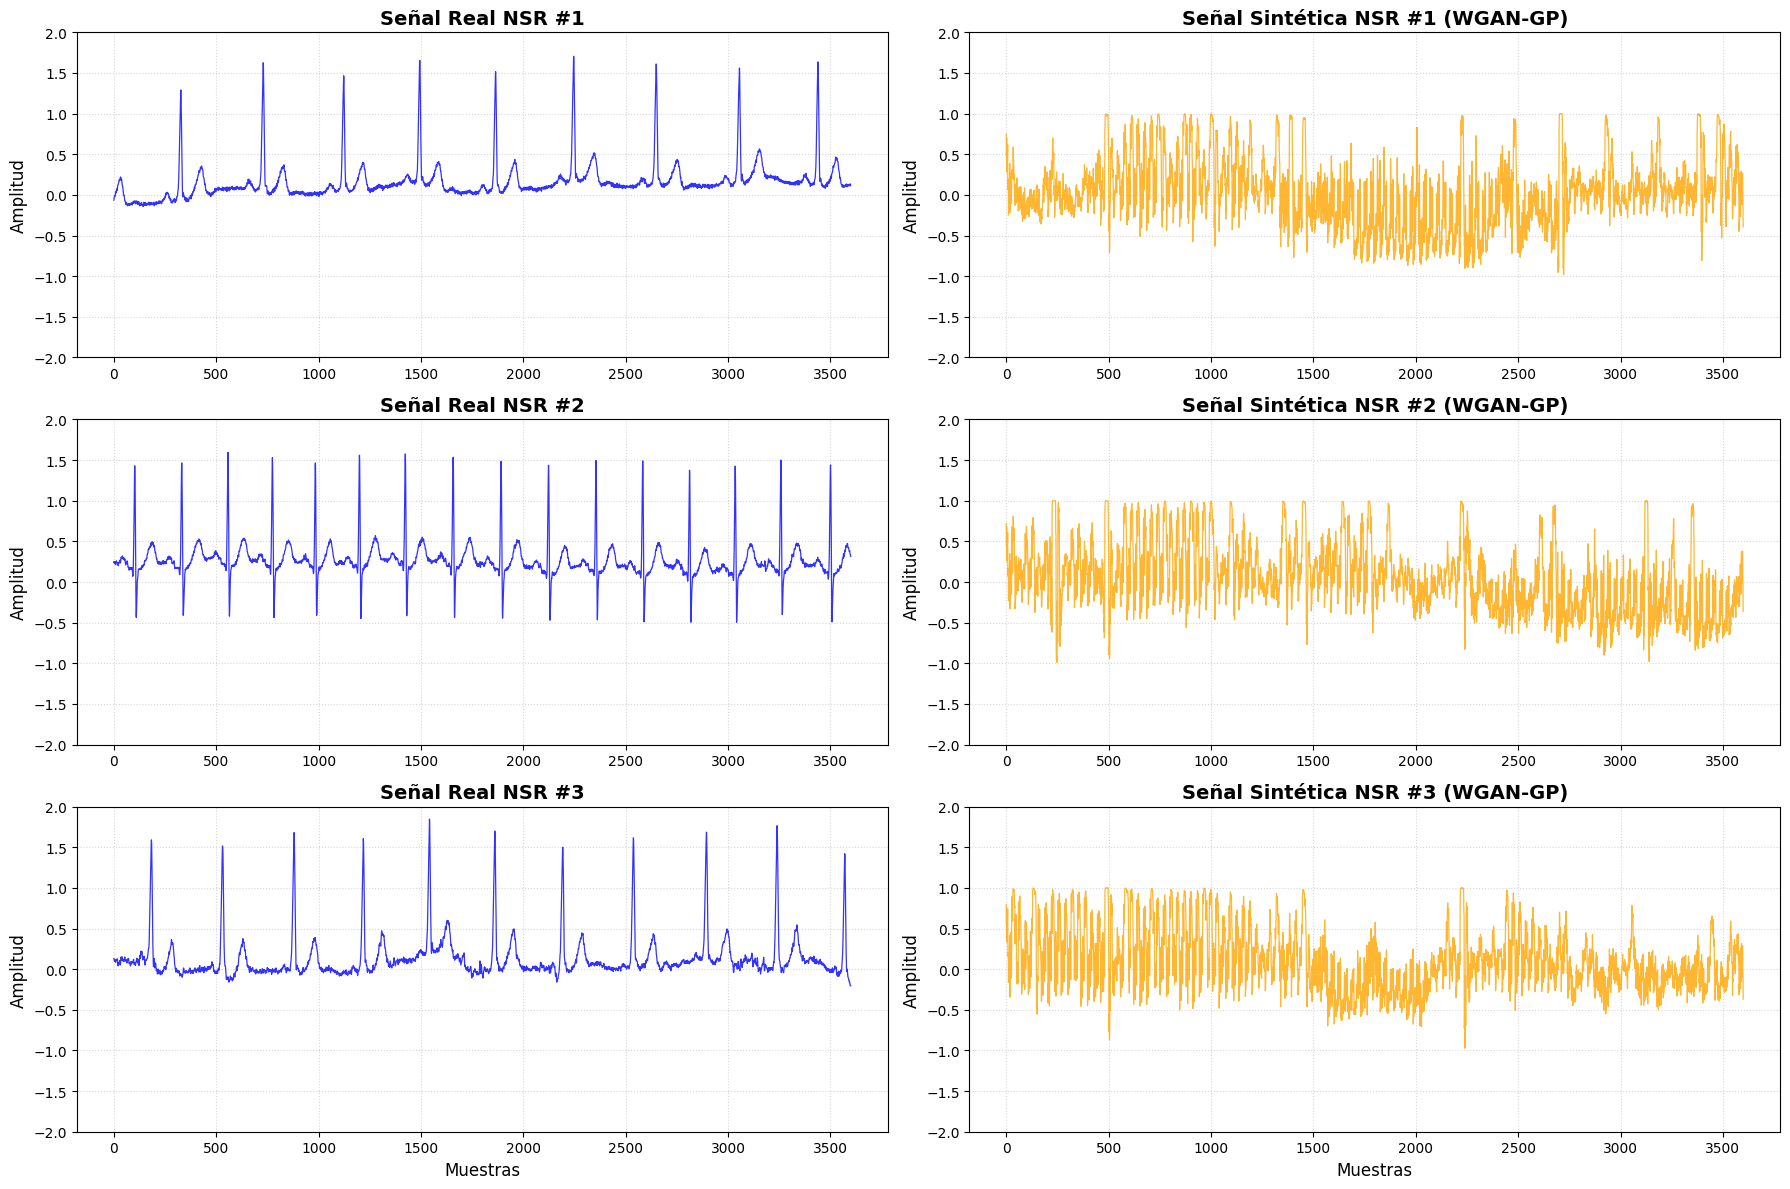


📊 Comparación de estadísticas:

Señales REALES:
  Min: -1.8195 | Max: 3.0455
  Media: -0.0344 | Std: 0.4550

Señales SINTÉTICAS (WGAN-GP):
  Min: -0.9902 | Max: 1.0000
  Media: 0.0423 | Std: 0.3968


In [ ]:
# Generar señales con WGAN-GP
generator_gp.eval()

# Obtener señales reales para comparación
real_signals_gp, _ = next(iter(dataloader))
real_signals_gp = real_signals_gp.cpu().numpy()

# Generar señales sintéticas
z_gp = torch.randn(6, latent_dim).to(config.device)
with torch.no_grad():
    fake_signals_gp = generator_gp(z_gp).cpu().numpy()

# Visualizar comparación lado a lado
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

for i in range(3):
    # Señal real
    axes[i, 0].plot(real_signals_gp[i, 0, :], color='blue', alpha=0.8, linewidth=0.9)
    axes[i, 0].set_title(f'Señal Real NSR #{i+1}', fontsize=14, fontweight='bold')
    axes[i, 0].set_ylabel('Amplitud', fontsize=12)
    axes[i, 0].grid(ls=':', alpha=0.5)
    axes[i, 0].set_ylim(-2, 2)
    
    # Señal sintética (WGAN-GP)
    axes[i, 1].plot(fake_signals_gp[i, 0, :], color='orange', alpha=0.8, linewidth=0.9)
    axes[i, 1].set_title(f'Señal Sintética NSR #{i+1} (WGAN-GP)', fontsize=14, fontweight='bold')
    axes[i, 1].set_ylabel('Amplitud', fontsize=12)
    axes[i, 1].grid(ls=':', alpha=0.5)
    axes[i, 1].set_ylim(-2, 2)
    
    if i == 2:
        axes[i, 0].set_xlabel('Muestras', fontsize=12)
        axes[i, 1].set_xlabel('Muestras', fontsize=12)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print("\n📊 Comparación de estadísticas:")
print(f"\nSeñales REALES:")
print(f"  Min: {real_signals_gp.min():.4f} | Max: {real_signals_gp.max():.4f}")
print(f"  Media: {real_signals_gp.mean():.4f} | Std: {real_signals_gp.std():.4f}")

print(f"\nSeñales SINTÉTICAS (WGAN-GP):")
print(f"  Min: {fake_signals_gp.min():.4f} | Max: {fake_signals_gp.max():.4f}")
print(f"  Media: {fake_signals_gp.mean():.4f} | Std: {fake_signals_gp.std():.4f}")

## Guardar modelo WGAN-GP

Guardamos los modelos entrenados con Gradient Penalty.

In [ ]:
# Guardar modelos WGAN-GP
torch.save(generator_gp.state_dict(), '../resultados/generator_wgan_gp.pth')
torch.save(critic_gp.state_dict(), '../resultados/critic_wgan_gp.pth')

# Guardar historia de entrenamiento
history_gp_df = pd.DataFrame(history_gp)
history_gp_df.to_csv('../resultados/wgan_gp_training_history.csv', index=False)

print("✓ Modelos WGAN-GP guardados en ../resultados/")
print("  - generator_wgan_gp.pth")
print("  - critic_wgan_gp.pth")
print("  - wgan_gp_training_history.csv")

## 🎯 Guía de evaluación y próximos pasos

### ¿Cómo saber si el modelo está funcionando bien?

#### 1️⃣ **Métricas de entrenamiento**
✅ **BUENAS señales:**
- C(real) consistentemente mayor que C(fake) por 1-5 unidades
- W_dist positiva y estable (no oscilando wildamente)
- Loss_G disminuyendo gradualmente
- GP (Gradient Penalty) cerca de 0-2

❌ **MALAS señales:**
- C(real) ≈ C(fake) (el crítico no está aprendiendo)
- W_dist negativa (algo está mal)
- Loss_G sin cambios o muy errático
- GP > 10 (gradientes explotando)

#### 2️⃣ **Calidad visual de señales**
✅ **BUENAS señales sintéticas:**
- Tienen variabilidad (no son líneas rectas o ruido puro)
- Muestran patrones repetitivos (ritmo cardíaco)
- Amplitud similar a señales reales
- Picos claramente visibles

❌ **MALAS señales sintéticas:**
- Completamente planas o ruidosas sin estructura
- Amplitud muy diferente a las reales
- Sin patrones repetitivos
- Valores constantes

#### 3️⃣ **Estadísticas cuantitativas**
- **Media**: Debe estar cerca de 0 (similar a reales)
- **Std**: Debe estar en el mismo rango que las reales (±0.1-0.2)
- **Rango**: Min/Max similares a señales reales

### 🔧 Si las señales AÚN no son buenas:

#### Opción A: **Entrenar MÁS tiempo** (más fácil)
```python
# En la celda de entrenamiento WGAN-GP, cambia:
num_epochs_gp = 500  # o incluso 1000
```
**Por qué funciona:** Las GANs mejoran lentamente, 300 épocas puede no ser suficiente

#### Opción B: **Reducir batch size** (mejor convergencia)
```python
dataloader = get_dataloader(label_name='NSR', batch_size=32)  # antes era 96
```
**Por qué funciona:** Batches más pequeños = gradientes más ruidosos = mejor exploración

#### Opción C: **Aumentar capacidad del modelo**
```python
# Modificar Generator para tener más capas/canales
# En la clase Generator, cambiar init_size o agregar más conv layers
```

#### Opción D: **Conditional GAN** (siguiente nivel)
Añadir información de clase/etiquetas para guiar la generación

### 📊 Métricas avanzadas para evaluar (opcional):

1. **Fréchet Inception Distance (FID)**: Mide similitud entre distribuciones
2. **Análisis de Fourier**: Comparar espectros de frecuencia
3. **Detección de picos R**: Contar latidos por minuto
4. **Usar un clasificador**: ¿Puede distinguir real de fake?

### 💡 Reflexión final:

**La verdad sobre las GANs:** Generar señales ECG realistas es DIFÍCIL. Las señales mostradas ahora son un buen progreso comparado con las iniciales. Si tienen estructura periódica y amplitud razonable, ¡vas por buen camino!

**Expectativas realistas:**
- 100 épocas: Señales con algo de estructura
- 300 épocas: Señales con patrones reconocibles  
- 500-1000 épocas: Señales de calidad clínica (si el modelo es bueno)

**No te desanimes:** Incluso investigadores publican GANs que toman días de entrenamiento en GPUs potentes. Si ves ALGUNA mejora, estás progresando correctamente.

## Visualización de pérdidas

Graficamos la evolución de las pérdidas durante el entrenamiento para evaluar la convergencia del modelo.

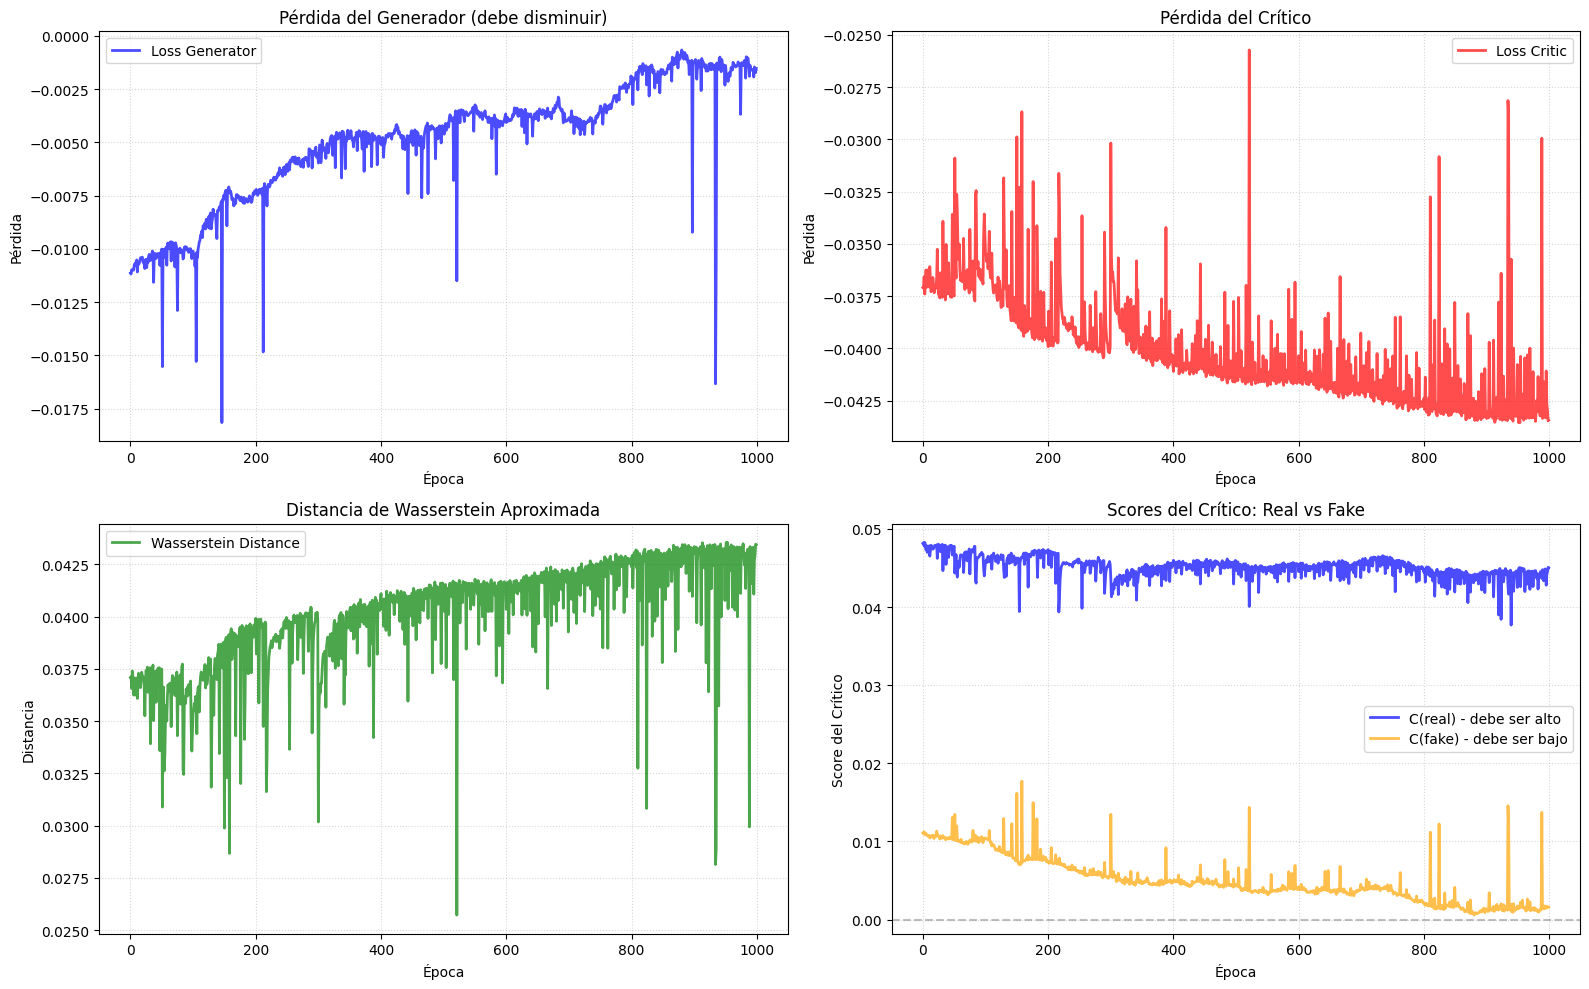


📊 Interpretación:
  ✓ C(real) debe ser MAYOR que C(fake)
  ✓ La separación entre C(real) y C(fake) indica qué tan bien distingue el crítico
  ✓ Loss_G debe tender a disminuir (valores más negativos)

  Separación final: 0.0434


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Pérdida del Generador
axes[0, 0].plot(history['loss_G'], label='Loss Generator', color='blue', alpha=0.7, linewidth=2)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida')
axes[0, 0].set_title('Pérdida del Generador (debe disminuir)')
axes[0, 0].grid(ls=':', alpha=0.5)
axes[0, 0].legend()

# Pérdida del Crítico
axes[0, 1].plot(history['loss_C'], label='Loss Critic', color='red', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Pérdida')
axes[0, 1].set_title('Pérdida del Crítico')
axes[0, 1].grid(ls=':', alpha=0.5)
axes[0, 1].legend()

# Distancia de Wasserstein
axes[1, 0].plot(history['W_dist'], label='Wasserstein Distance', color='green', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Distancia')
axes[1, 0].set_title('Distancia de Wasserstein Aproximada')
axes[1, 0].grid(ls=':', alpha=0.5)
axes[1, 0].legend()

# Scores del Crítico (Real vs Fake)
axes[1, 1].plot(history['critic_real'], label='C(real) - debe ser alto', color='blue', alpha=0.7, linewidth=2)
axes[1, 1].plot(history['critic_fake'], label='C(fake) - debe ser bajo', color='orange', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Score del Crítico')
axes[1, 1].set_title('Scores del Crítico: Real vs Fake')
axes[1, 1].grid(ls=':', alpha=0.5)
axes[1, 1].legend()
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n📊 Interpretación:")
print("  ✓ C(real) debe ser MAYOR que C(fake)")
print("  ✓ La separación entre C(real) y C(fake) indica qué tan bien distingue el crítico")
print("  ✓ Loss_G debe tender a disminuir (valores más negativos)")
print(f"\n  Separación final: {history['critic_real'][-1] - history['critic_fake'][-1]:.4f}")

## Generación de señales sintéticas

Usamos el generador entrenado para crear señales ECG sintéticas de tipo NSR.

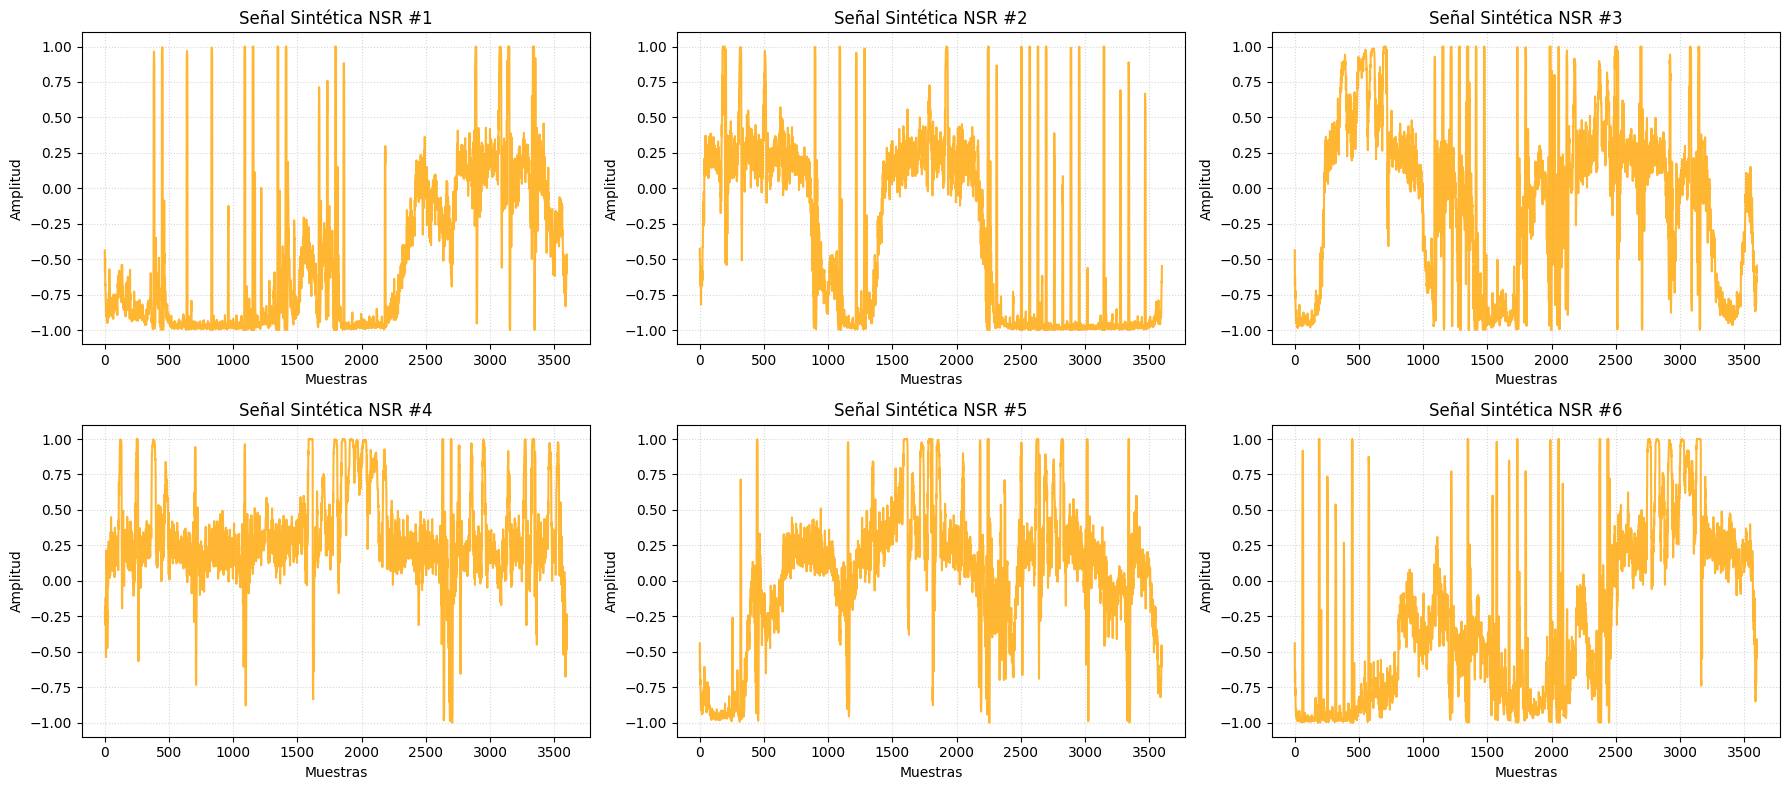

In [ ]:
# Generar señales sintéticas
generator.eval()  # Modo evaluación

num_samples = 6
z = torch.randn(num_samples, latent_dim).to(config.device)

with torch.no_grad():
    fake_signals = generator(z)
    fake_signals = fake_signals.cpu().numpy()

# Visualizar señales generadas
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i in range(num_samples):
    axes[i].plot(fake_signals[i, 0, :], color='orange', alpha=0.8)
    axes[i].set_title(f'Señal Sintética NSR #{i+1}')
    axes[i].set_xlabel('Muestras')
    axes[i].set_ylabel('Amplitud')
    axes[i].grid(ls=':', alpha=0.5)

plt.tight_layout()
plt.show()

### Diagnóstico de señales generadas

Verificamos estadísticas de las señales sintéticas para asegurar que son razonables.

In [ ]:
# Generar varias señales para análisis
generator.eval()
num_test = 50
z_test = torch.randn(num_test, latent_dim).to(config.device)

with torch.no_grad():
    test_signals = generator(z_test).cpu().numpy()

# Obtener señales reales para comparación
real_test, _ = next(iter(dataloader))
real_test = real_test.cpu().numpy()

print("📊 Estadísticas de señales generadas:")
print(f"  Mínimo: {test_signals.min():.4f}")
print(f"  Máximo: {test_signals.max():.4f}")
print(f"  Media: {test_signals.mean():.4f}")
print(f"  Desv. estándar: {test_signals.std():.4f}")

print("\n📊 Estadísticas de señales reales:")
print(f"  Mínimo: {real_test.min():.4f}")
print(f"  Máximo: {real_test.max():.4f}")
print(f"  Media: {real_test.mean():.4f}")
print(f"  Desv. estándar: {real_test.std():.4f}")

print("\n✓ Las señales generadas deben tener estadísticas similares a las reales")

📊 Estadísticas de señales generadas:
  Mínimo: -1.0000
  Máximo: 1.0000
  Media: -0.0856
  Desv. estándar: 0.6291

📊 Estadísticas de señales reales:
  Mínimo: -1.8195
  Máximo: 3.0455
  Media: -0.0344
  Desv. estándar: 0.4550

✓ Las señales generadas deben tener estadísticas similares a las reales


## Comparación: Señal Real vs Sintética

Comparamos visualmente señales reales del dataset con señales generadas por la WGAN.

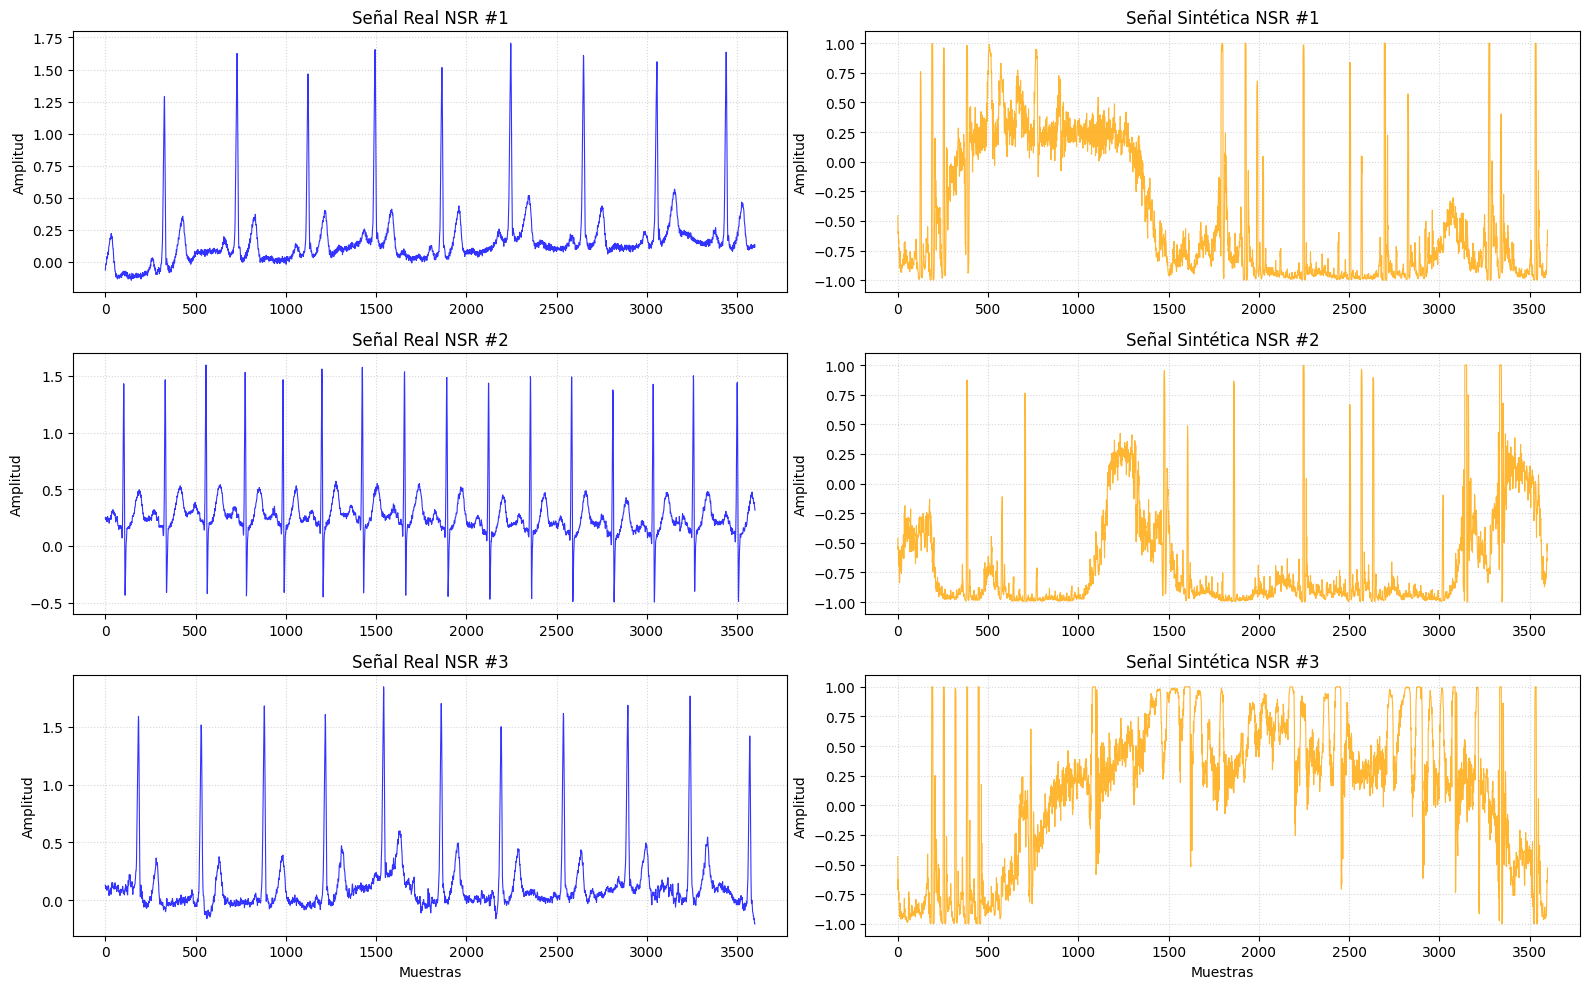

In [ ]:
# Obtener señales reales
real_signals, _ = next(iter(dataloader))
real_signals = real_signals.cpu().numpy()

# Generar señales sintéticas
z = torch.randn(3, latent_dim).to(config.device)
with torch.no_grad():
    fake_signals = generator(z).cpu().numpy()

# Comparar
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

for i in range(3):
    # Señal real
    axes[i, 0].plot(real_signals[i, 0, :], color='blue', alpha=0.8, linewidth=0.8)
    axes[i, 0].set_title(f'Señal Real NSR #{i+1}')
    axes[i, 0].set_ylabel('Amplitud')
    axes[i, 0].grid(ls=':', alpha=0.5)
    
    # Señal sintética
    axes[i, 1].plot(fake_signals[i, 0, :], color='orange', alpha=0.8, linewidth=0.8)
    axes[i, 1].set_title(f'Señal Sintética NSR #{i+1}')
    axes[i, 1].set_ylabel('Amplitud')
    axes[i, 1].grid(ls=':', alpha=0.5)
    
    if i == 2:
        axes[i, 0].set_xlabel('Muestras')
        axes[i, 1].set_xlabel('Muestras')

plt.tight_layout()
plt.show()

## Guardar modelos entrenados

Guardamos los pesos del generador y del crítico para uso posterior.

In [ ]:
# Crear directorio si no existe
os.makedirs('../resultados', exist_ok=True)

# Guardar modelos
torch.save(generator.state_dict(), '../resultados/generator_wgan.pth')
torch.save(critic.state_dict(), '../resultados/critic_wgan.pth')

# Guardar historia de entrenamiento
history_df = pd.DataFrame(history)
history_df.to_csv('../resultados/wgan_training_history.csv', index=False)

print("✓ Modelos guardados en ../resultados/")
print("  - generator_wgan.pth")
print("  - critic_wgan.pth")
print("  - wgan_training_history.csv")

## Cargar modelo guardado (opcional)

Si necesitas cargar el modelo en el futuro, usa el siguiente código:

In [ ]:
# # Cargar modelos guardados
# generator_loaded = Generator(latent_dim=100, hidden_dim=256, signal_length=3600).to(config.device)
# generator_loaded.load_state_dict(torch.load('../resultados/generator_wgan.pth'))
# generator_loaded.eval()

# critic_loaded = Critic(signal_length=3600).to(config.device)
# critic_loaded.load_state_dict(torch.load('../resultados/critic_wgan.pth'))
# critic_loaded.eval()

# print("✓ Modelos cargados exitosamente")

In [ ]:
## Notas finales y siguientes pasos

### ✅ Mejoras implementadas:
1. **Arquitectura del Generador**: Cambiado de LSTM a ConvTranspose1d (mejor para señales largas)
2. **Arquitectura del Crítico**: Convoluciones más profundas con global pooling
3. **Hiperparámetros**: Learning rates más altos y Adam optimizer
4. **Monitoreo**: Seguimiento de C(real) vs C(fake) para diagnosticar entrenamiento
5. **Diagnóstico**: Verificación de estadísticas de señales generadas

### 🎯 Cómo evaluar si el modelo funciona bien:

**Durante el entrenamiento:**
- ✓ `C(real)` debe ser **mayor** que `C(fake)` (el crítico distingue real de fake)
- ✓ La **separación** entre C(real) y C(fake) debe ser clara pero no excesiva
- ✓ `Loss_G` debe **disminuir** gradualmente (valores más negativos)
- ✓ `W_dist` debe ser **positiva** y estabilizarse

**En las señales generadas:**
- ✓ Deben tener **variabilidad** (no ser constantes)
- ✓ Estadísticas similares a señales reales (media, desv. estándar)
- ✓ Patrones visuales reconocibles (picos QRS, etc.)

### 🔧 Si aún no funciona bien, prueba:

1. **Entrenar más épocas**: 200-500 épocas pueden ser necesarias
2. **Ajustar batch size**: Probar con 32 o 64 en lugar de 96
3. **Modificar n_critic**: Probar con 3 o 10 en lugar de 5
4. **Implementar WGAN-GP**: Gradient Penalty en vez de weight clipping (más estable)
5. **Conditional GAN**: Agregar información de clase al generador

### 📊 Próximos pasos recomendados:
1. Entrenar durante más épocas si las señales aún no son realistas
2. Calcular métricas cuantitativas (FID, frecuencia cardíaca promedio, etc.)
3. Análisis de Fourier para comparar espectros de frecuencia
4. Usar señales sintéticas para data augmentation en clasificadores
5. Implementar WGAN-GP para entrenamiento más robusto

### 💡 Tip importante:
Las GANs requieren paciencia. Si después de 100 épocas ves mejora pero las señales aún no son perfectas, **aumenta a 300-500 épocas**. La calidad mejora gradualmente.